In [28]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
import time
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50

In [29]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =448
        self.n_augment = max(n_augment , 4)
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224)),
                transforms.RandomRotation(5),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ]
            )
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

In [30]:
# del training_dataloader
batch_size = 128
lr = 0.2
suffix = '%f' % time.time()
log_dir = './log/%s'% suffix +'/'
EXPERIMENT = 'resnet50_%s'% str(lr)
os.mkdir(log_dir)
print(suffix)
print(log_dir)
print(EXPERIMENT)

training_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)

1592012616.259060
./log/1592012616.259060/
resnet50_0.2


In [31]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every  iterations, print loss
        if (i + 1) % (10) == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [32]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy,cm

In [33]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [34]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    cms = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy,cm = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        cms.append(cm)
        torch.save(cm,log_dir+str(epoch)+'_cms.pth')   
        torch.save(loss,log_dir+str(epoch)+'_tls.pth')   
        torch.save(accuracy,log_dir+str(epoch)+'_tas.pth')   
    torch.save(cms,log_dir+EXPERIMENT+'_cms.pth')   
    torch.save(losses,log_dir+EXPERIMENT+'_tls.pth')   
    torch.save(accs,log_dir+EXPERIMENT+'_tas.pth')   
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [35]:
net = resnet50(pretrained=True)
net.fc = torch.nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.6),
                             nn.Linear(512, 40)
                            )

In [36]:
# Hyper-parameters
num_epochs = 40
nclasses = 40
feature_tune=False
# Device configuration
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


for parma in net.parameters():
    parma.requires_grad = feature_tune
for param in net.fc.parameters():
    param.requires_grad = True
for param in net.avgpool.parameters():
    param.requires_grad = True
for param in net.layer4.parameters():
    param.requires_grad = True

# # optimizer
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
# lr = 0.2
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 10 , gamma = 0.6)
for name,param in net.named_parameters():
    print(param.requires_grad, name)

False conv1.weight
False bn1.weight
False bn1.bias
False layer1.0.conv1.weight
False layer1.0.bn1.weight
False layer1.0.bn1.bias
False layer1.0.conv2.weight
False layer1.0.bn2.weight
False layer1.0.bn2.bias
False layer1.0.conv3.weight
False layer1.0.bn3.weight
False layer1.0.bn3.bias
False layer1.0.downsample.0.weight
False layer1.0.downsample.1.weight
False layer1.0.downsample.1.bias
False layer1.1.conv1.weight
False layer1.1.bn1.weight
False layer1.1.bn1.bias
False layer1.1.conv2.weight
False layer1.1.bn2.weight
False layer1.1.bn2.bias
False layer1.1.conv3.weight
False layer1.1.bn3.weight
False layer1.1.bn3.bias
False layer1.2.conv1.weight
False layer1.2.bn1.weight
False layer1.2.bn1.bias
False layer1.2.conv2.weight
False layer1.2.bn2.weight
False layer1.2.bn2.bias
False layer1.2.conv3.weight
False layer1.2.bn3.weight
False layer1.2.bn3.bias
False layer2.0.conv1.weight
False layer2.0.bn1.weight
False layer2.0.bn1.bias
False layer2.0.conv2.weight
False layer2.0.bn2.weight
False layer2

Epoch 1/40: , lr = 0.2
Step [10/60] Train Loss: 3.5683
Step [20/60] Train Loss: 3.2018
Step [30/60] Train Loss: 2.8470
Step [40/60] Train Loss: 2.5836
Step [50/60] Train Loss: 2.4140
Step [60/60] Train Loss: 2.0220
Accuracy on Test Set: 35.4167 %


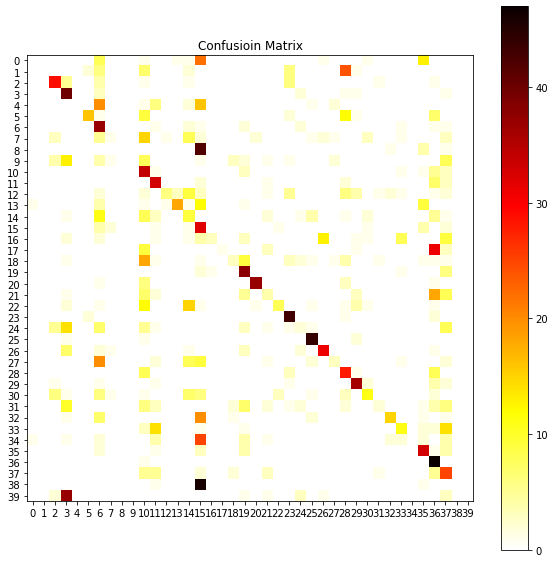

Accuracy of each class:
 tensor([0.0000, 0.0000, 0.6042, 0.8333, 0.0000, 0.3333, 0.7708, 0.0208, 0.0000,
        0.0000, 0.7083, 0.6875, 0.1250, 0.3750, 0.1875, 0.6667, 0.0625, 0.0208,
        0.0625, 0.7917, 0.7708, 0.0833, 0.1667, 0.8958, 0.0417, 0.9167, 0.6458,
        0.0625, 0.5833, 0.7500, 0.2292, 0.0417, 0.3125, 0.2292, 0.0000, 0.6875,
        0.9792, 0.5208, 0.0000, 0.0000])
Recall of each class:
 tensor([0.0000, 0.0000, 0.5800, 0.2920, 0.0000, 0.8000, 0.2313, 0.1667, 0.0000,
        0.0000, 0.2012, 0.4074, 0.7500, 0.8182, 0.1324, 0.1265, 0.7500, 1.0000,
        0.2727, 0.4419, 0.9250, 0.1905, 0.6667, 0.5972, 0.1250, 0.7586, 0.6458,
        0.3333, 0.3182, 0.6545, 0.5000, 0.3333, 0.7500, 0.4074, 0.0000, 0.4583,
        0.3032, 0.2066, 0.0000, 0.0000])
Epoch 2/40: , lr = 0.2
Step [10/60] Train Loss: 1.9008
Step [20/60] Train Loss: 1.9246
Step [30/60] Train Loss: 1.5184
Step [40/60] Train Loss: 1.6573
Step [50/60] Train Loss: 1.6619
Step [60/60] Train Loss: 1.5710
Accuracy on Tes

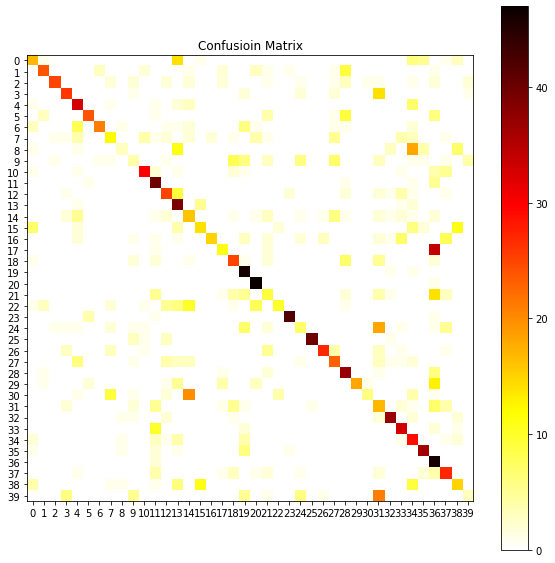

Accuracy of each class:
 tensor([0.3542, 0.5000, 0.5208, 0.5417, 0.6875, 0.5000, 0.4375, 0.2500, 0.0625,
        0.0833, 0.6250, 0.8333, 0.5208, 0.8125, 0.3333, 0.2917, 0.3125, 0.2292,
        0.5208, 0.9583, 0.9792, 0.1875, 0.2083, 0.8750, 0.1458, 0.8333, 0.5625,
        0.4792, 0.7708, 0.3750, 0.1250, 0.3542, 0.7708, 0.6875, 0.6042, 0.7500,
        0.9583, 0.5625, 0.3125, 0.0625])
Recall of each class:
 tensor([0.4359, 0.7273, 0.8929, 0.6190, 0.5000, 0.7742, 0.8400, 0.3636, 0.3750,
        0.1667, 0.7500, 0.4819, 0.4902, 0.3645, 0.2667, 0.4516, 0.8824, 0.4783,
        0.4902, 0.4842, 0.6912, 0.2250, 0.6250, 0.9130, 0.2593, 0.9756, 0.8438,
        0.4510, 0.5068, 1.0000, 0.7500, 0.1700, 0.7872, 0.5690, 0.2990, 0.7200,
        0.3026, 0.4655, 0.3659, 0.3000])
Epoch 3/40: , lr = 0.2
Step [10/60] Train Loss: 1.2485
Step [20/60] Train Loss: 1.1556
Step [30/60] Train Loss: 1.3028
Step [40/60] Train Loss: 1.1824
Step [50/60] Train Loss: 1.3090
Step [60/60] Train Loss: 1.0545
Accuracy on Tes

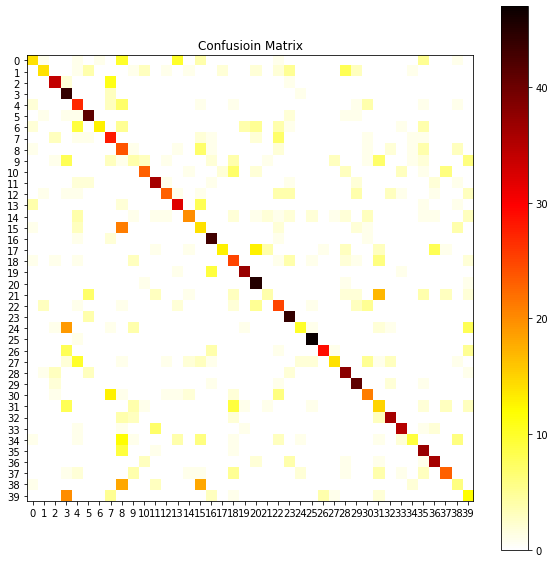

Accuracy of each class:
 tensor([0.2917, 0.2917, 0.7083, 0.9167, 0.5625, 0.8542, 0.2708, 0.5833, 0.5000,
        0.0833, 0.4792, 0.7500, 0.4792, 0.6667, 0.4167, 0.2917, 0.8958, 0.2708,
        0.5208, 0.7708, 0.9375, 0.0833, 0.5208, 0.9167, 0.2083, 0.9792, 0.6042,
        0.2917, 0.7917, 0.8542, 0.4375, 0.3125, 0.7500, 0.7292, 0.1875, 0.7708,
        0.7500, 0.4792, 0.1250, 0.2500])
Recall of each class:
 tensor([0.5185, 0.6667, 0.7391, 0.3860, 0.3971, 0.6613, 0.9286, 0.4058, 0.2051,
        0.1538, 0.6765, 0.6923, 0.7931, 0.6154, 0.6897, 0.2154, 0.6515, 0.7647,
        0.3846, 0.8409, 0.5844, 0.3333, 0.4098, 0.6286, 0.6250, 0.8545, 0.8529,
        0.7000, 0.6129, 0.6833, 0.4884, 0.2419, 0.7660, 0.7955, 0.6000, 0.5362,
        0.7200, 0.6389, 0.2500, 0.2609])
Epoch 4/40: , lr = 0.2
Step [10/60] Train Loss: 0.9211
Step [20/60] Train Loss: 1.0379
Step [30/60] Train Loss: 0.9927
Step [40/60] Train Loss: 0.6981
Step [50/60] Train Loss: 1.2417
Step [60/60] Train Loss: 1.2759
Accuracy on Tes

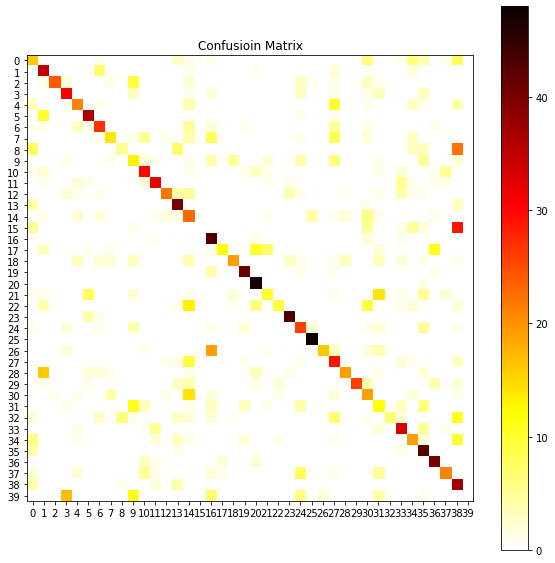

Accuracy of each class:
 tensor([0.3333, 0.7292, 0.5000, 0.6458, 0.4375, 0.7500, 0.5625, 0.2917, 0.1042,
        0.2708, 0.6250, 0.6667, 0.4583, 0.8333, 0.4792, 0.0000, 0.8958, 0.2500,
        0.3958, 0.8542, 0.9792, 0.2083, 0.1875, 0.8958, 0.5417, 1.0000, 0.3333,
        0.6042, 0.3958, 0.5417, 0.3958, 0.2500, 0.1458, 0.6875, 0.3958, 0.8750,
        0.8333, 0.4375, 0.7708, 0.0000])
Recall of each class:
 tensor([0.2759, 0.4605, 0.9600, 0.5345, 0.5676, 0.6667, 0.5510, 0.5833, 0.4167,
        0.2203, 0.5769, 0.6957, 0.8148, 0.5634, 0.2347, 0.0000, 0.4257, 0.8000,
        0.6786, 0.8039, 0.6351, 0.4167, 0.6923, 0.8269, 0.4333, 0.8727, 0.8889,
        0.3580, 0.7600, 1.0000, 0.2969, 0.2105, 1.0000, 0.5593, 0.3958, 0.4719,
        0.6667, 0.6774, 0.2721, 0.0000])
Epoch 5/40: , lr = 0.2
Step [10/60] Train Loss: 0.7930
Step [20/60] Train Loss: 0.9251
Step [30/60] Train Loss: 0.9305
Step [40/60] Train Loss: 0.9618
Step [50/60] Train Loss: 0.6824
Step [60/60] Train Loss: 0.8484
Accuracy on Tes

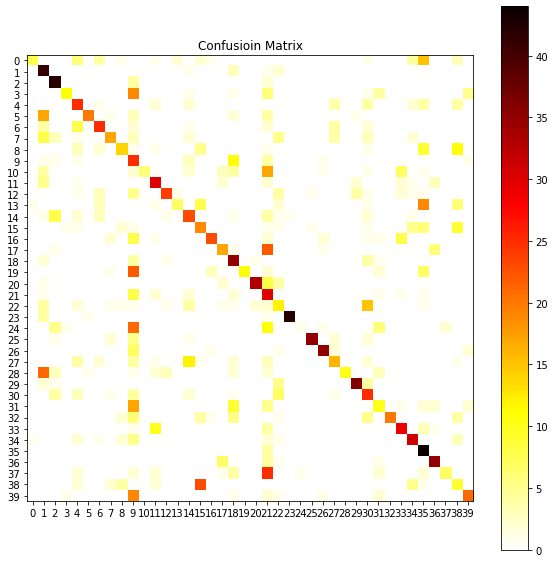

Accuracy of each class:
 tensor([0.1667, 0.8542, 0.8750, 0.2292, 0.5208, 0.4167, 0.5208, 0.3542, 0.2917,
        0.5208, 0.1250, 0.6250, 0.5000, 0.1458, 0.4792, 0.3958, 0.4792, 0.3542,
        0.7292, 0.2292, 0.6875, 0.6250, 0.2500, 0.8750, 0.0208, 0.7292, 0.7292,
        0.3333, 0.2083, 0.7500, 0.5208, 0.2083, 0.4167, 0.6042, 0.6458, 0.9167,
        0.7292, 0.1458, 0.1875, 0.4375])
Recall of each class:
 tensor([0.8000, 0.3534, 0.6087, 0.7857, 0.3906, 0.9091, 0.5682, 0.6296, 0.5385,
        0.1250, 1.0000, 0.5455, 0.8000, 0.7000, 0.4107, 0.3065, 0.7931, 0.5152,
        0.4118, 1.0000, 0.9167, 0.1734, 0.2500, 0.9767, 0.5000, 0.9459, 0.8333,
        0.4848, 1.0000, 0.8372, 0.3289, 0.3030, 1.0000, 0.5800, 0.5962, 0.3793,
        0.7447, 0.7778, 0.1800, 0.6774])
Epoch 6/40: , lr = 0.2
Step [10/60] Train Loss: 0.6452
Step [20/60] Train Loss: 0.8043
Step [30/60] Train Loss: 0.7808
Step [40/60] Train Loss: 0.5381
Step [50/60] Train Loss: 0.9542
Step [60/60] Train Loss: 0.6122
Accuracy on Tes

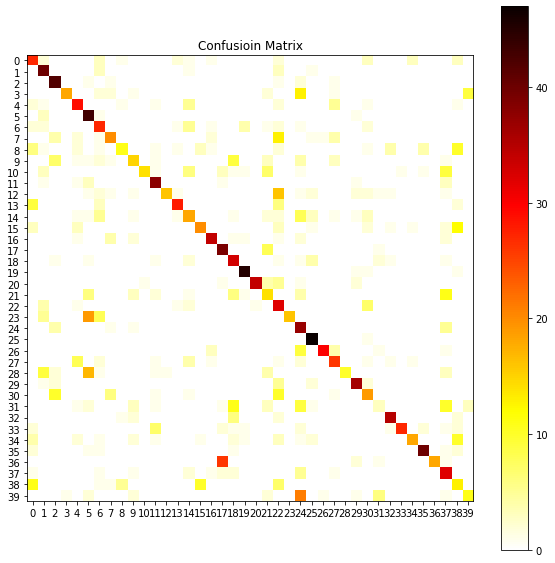

Accuracy of each class:
 tensor([0.5625, 0.8333, 0.8750, 0.3750, 0.6042, 0.8958, 0.5625, 0.4167, 0.2292,
        0.3125, 0.2917, 0.7917, 0.3333, 0.5833, 0.3750, 0.4167, 0.7083, 0.8125,
        0.6875, 0.9375, 0.7083, 0.2917, 0.6667, 0.3333, 0.7708, 0.9792, 0.6250,
        0.5417, 0.2083, 0.7500, 0.3958, 0.0625, 0.7292, 0.5625, 0.3750, 0.8333,
        0.3750, 0.6667, 0.2708, 0.2292])
Recall of each class:
 tensor([0.3913, 0.5556, 0.5833, 0.9474, 0.5577, 0.4388, 0.4154, 0.5405, 0.5789,
        0.4412, 0.9333, 0.6667, 0.9412, 0.8000, 0.3750, 0.5882, 0.7727, 0.5200,
        0.4459, 0.8333, 0.9714, 0.2800, 0.2689, 1.0000, 0.2984, 0.7344, 0.9375,
        0.5532, 1.0000, 0.7660, 0.4222, 0.2000, 0.7955, 0.9643, 0.7826, 0.8511,
        1.0000, 0.3765, 0.2241, 0.4783])
Epoch 7/40: , lr = 0.2
Step [10/60] Train Loss: 0.5834
Step [20/60] Train Loss: 0.9647
Step [30/60] Train Loss: 0.6825
Step [40/60] Train Loss: 0.5914
Step [50/60] Train Loss: 0.6484
Step [60/60] Train Loss: 0.7229
Accuracy on Tes

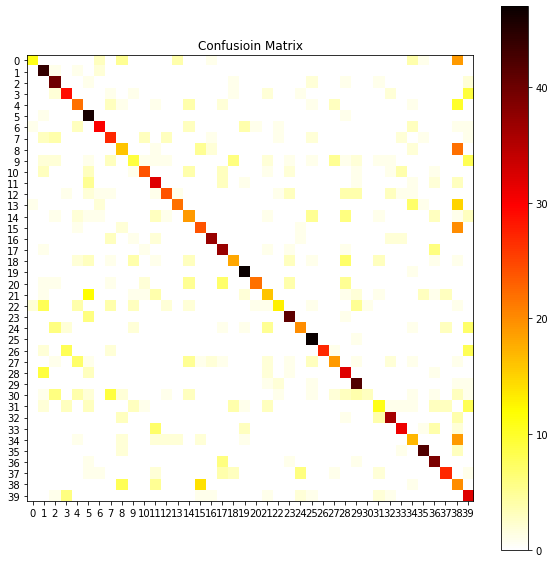

Accuracy of each class:
 tensor([0.2292, 0.9167, 0.8333, 0.6042, 0.4583, 0.9583, 0.6250, 0.5625, 0.3333,
        0.1875, 0.5000, 0.6667, 0.5000, 0.4583, 0.3958, 0.5000, 0.7708, 0.7708,
        0.3750, 0.9792, 0.4583, 0.3333, 0.2708, 0.8542, 0.4167, 0.9792, 0.5625,
        0.3958, 0.6667, 0.8750, 0.0625, 0.2292, 0.7500, 0.6458, 0.3542, 0.8750,
        0.8125, 0.5625, 0.4167, 0.6667])
Recall of each class:
 tensor([0.7333, 0.5641, 0.6154, 0.5918, 0.4681, 0.5055, 0.7500, 0.4909, 0.3902,
        0.3600, 0.7273, 0.5161, 0.7059, 0.7586, 0.3958, 0.5106, 0.8409, 0.5781,
        0.5455, 0.7833, 0.9167, 0.4211, 0.6842, 0.7069, 0.6452, 0.7121, 1.0000,
        0.6129, 0.5000, 0.6562, 0.7500, 0.4231, 0.7347, 0.7381, 0.4048, 0.8571,
        0.6290, 0.7500, 0.1370, 0.3902])
Epoch 8/40: , lr = 0.2
Step [10/60] Train Loss: 0.3832
Step [20/60] Train Loss: 0.4425
Step [30/60] Train Loss: 0.7385
Step [40/60] Train Loss: 0.6602
Step [50/60] Train Loss: 0.4974
Step [60/60] Train Loss: 0.5384
Accuracy on Tes

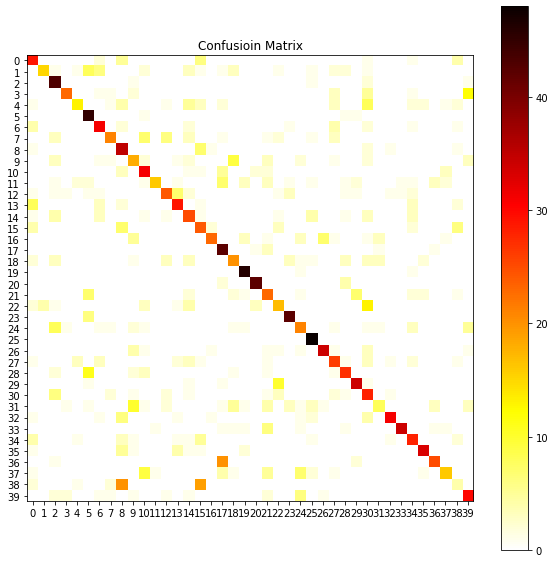

Accuracy of each class:
 tensor([0.6042, 0.3125, 0.8958, 0.4792, 0.2708, 0.9375, 0.6458, 0.4375, 0.7292,
        0.3750, 0.6458, 0.3333, 0.5000, 0.6042, 0.5208, 0.5000, 0.4792, 0.8750,
        0.4167, 0.9583, 0.8750, 0.4792, 0.3542, 0.8750, 0.4375, 1.0000, 0.7083,
        0.5417, 0.5625, 0.7083, 0.5833, 0.1667, 0.6458, 0.7083, 0.5833, 0.6875,
        0.5208, 0.3333, 0.0833, 0.6250])
Recall of each class:
 tensor([0.4603, 0.7895, 0.5443, 0.8214, 0.6190, 0.5488, 0.5741, 0.7000, 0.3804,
        0.3673, 0.4921, 0.8889, 0.6000, 0.6170, 0.4167, 0.3429, 0.8214, 0.4828,
        0.4651, 0.7931, 0.8750, 0.4035, 0.4359, 0.7925, 0.4565, 0.7385, 0.7907,
        0.5306, 0.6279, 0.7234, 0.3373, 0.5000, 0.8611, 0.9444, 0.5385, 0.8250,
        0.7576, 0.6667, 0.1667, 0.5455])
Epoch 9/40: , lr = 0.2
Step [10/60] Train Loss: 0.9729
Step [20/60] Train Loss: 0.7920
Step [30/60] Train Loss: 0.4320
Step [40/60] Train Loss: 0.4529
Step [50/60] Train Loss: 0.4211
Step [60/60] Train Loss: 0.4412
Accuracy on Tes

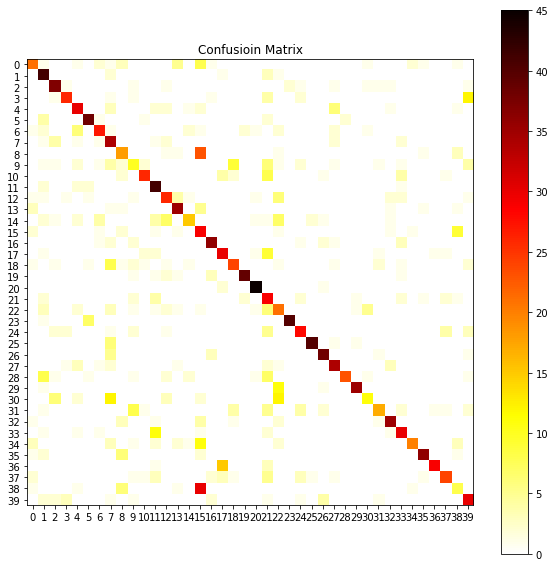

Accuracy of each class:
 tensor([0.4375, 0.8542, 0.7708, 0.5417, 0.6250, 0.7917, 0.5625, 0.7083, 0.3750,
        0.2083, 0.5417, 0.8542, 0.5417, 0.7292, 0.3125, 0.6042, 0.7500, 0.6250,
        0.5000, 0.8125, 0.9375, 0.6042, 0.4375, 0.8333, 0.5833, 0.8333, 0.7917,
        0.7083, 0.4792, 0.7292, 0.2292, 0.3542, 0.7292, 0.6250, 0.4167, 0.7500,
        0.6042, 0.5000, 0.1667, 0.6250])
Recall of each class:
 tensor([0.5676, 0.5325, 0.6607, 0.7647, 0.5660, 0.7600, 0.6750, 0.3778, 0.4091,
        0.2857, 0.7647, 0.5467, 0.5200, 0.6731, 0.6522, 0.2437, 0.7500, 0.5455,
        0.5854, 0.9070, 0.8824, 0.2959, 0.3043, 0.9524, 0.6364, 0.9302, 0.7600,
        0.6800, 0.9200, 0.9211, 0.5500, 0.6800, 0.7609, 0.6122, 0.8333, 0.8780,
        0.9355, 0.7273, 0.2857, 0.5263])
Epoch 10/40: , lr = 0.2
Step [10/60] Train Loss: 0.5574
Step [20/60] Train Loss: 0.4966
Step [30/60] Train Loss: 0.6015
Step [40/60] Train Loss: 0.5332
Step [50/60] Train Loss: 0.5427
Step [60/60] Train Loss: 0.5056
Accuracy on Te

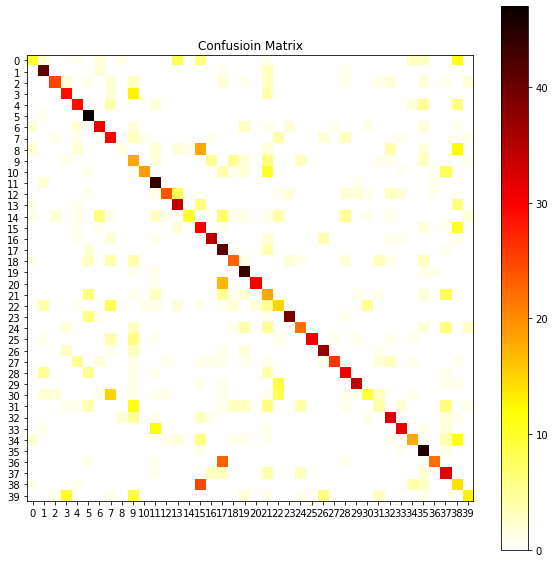

Accuracy of each class:
 tensor([0.2083, 0.8542, 0.5208, 0.6042, 0.6042, 0.9792, 0.6458, 0.6250, 0.0208,
        0.3750, 0.3958, 0.9167, 0.5000, 0.7083, 0.2083, 0.6250, 0.7292, 0.8542,
        0.4792, 0.9167, 0.6250, 0.3750, 0.3125, 0.8125, 0.4583, 0.6458, 0.7708,
        0.5417, 0.6458, 0.7083, 0.1875, 0.0833, 0.6667, 0.6458, 0.3750, 0.9375,
        0.4583, 0.6667, 0.2917, 0.2708])
Recall of each class:
 tensor([0.5000, 0.6949, 0.8065, 0.6042, 0.6170, 0.6104, 0.6739, 0.4054, 0.2500,
        0.2069, 0.9048, 0.5570, 0.8571, 0.5862, 0.9091, 0.3061, 0.7609, 0.3727,
        0.6053, 0.6377, 0.9375, 0.2118, 0.3571, 0.8667, 0.6471, 1.0000, 0.7400,
        0.9286, 0.6327, 0.8500, 0.5000, 0.2105, 0.6400, 0.7949, 0.6000, 0.5696,
        0.8462, 0.4324, 0.1867, 0.5652])
Epoch 11/40: , lr = 0.12
Step [10/60] Train Loss: 0.3682
Step [20/60] Train Loss: 0.3280
Step [30/60] Train Loss: 0.3934
Step [40/60] Train Loss: 0.3747
Step [50/60] Train Loss: 0.2685
Step [60/60] Train Loss: 0.4264
Accuracy on T

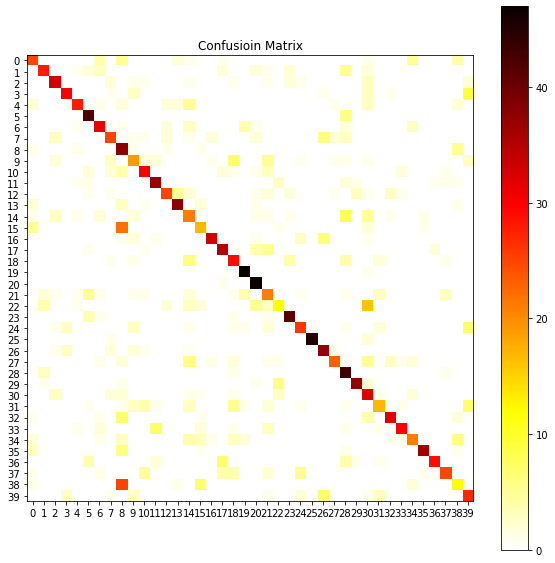

Accuracy of each class:
 tensor([0.5208, 0.5833, 0.6875, 0.6250, 0.5833, 0.8750, 0.6458, 0.5208, 0.7917,
        0.3958, 0.6250, 0.7708, 0.5208, 0.7917, 0.4375, 0.3542, 0.6875, 0.7292,
        0.6042, 0.9792, 0.9792, 0.4375, 0.2500, 0.8542, 0.5417, 0.9375, 0.7708,
        0.4792, 0.8958, 0.7708, 0.6667, 0.3542, 0.6667, 0.6250, 0.4375, 0.7500,
        0.6042, 0.5208, 0.2500, 0.5625])
Recall of each class:
 tensor([0.5682, 0.7368, 0.7021, 0.7692, 0.7778, 0.6667, 0.6327, 0.6098, 0.3089,
        0.4524, 0.6383, 0.7400, 0.7353, 0.7917, 0.3443, 0.4595, 0.8684, 0.6731,
        0.5000, 0.7966, 0.7015, 0.3889, 0.4615, 0.7885, 0.6500, 1.0000, 0.6491,
        0.7931, 0.5181, 0.8810, 0.3765, 0.5667, 0.7805, 0.8333, 0.6000, 0.9231,
        0.9062, 0.7812, 0.3529, 0.4909])
Epoch 12/40: , lr = 0.12
Step [10/60] Train Loss: 0.2393
Step [20/60] Train Loss: 0.3571
Step [30/60] Train Loss: 0.1998
Step [40/60] Train Loss: 0.3381
Step [50/60] Train Loss: 0.3327
Step [60/60] Train Loss: 0.4066
Accuracy on T

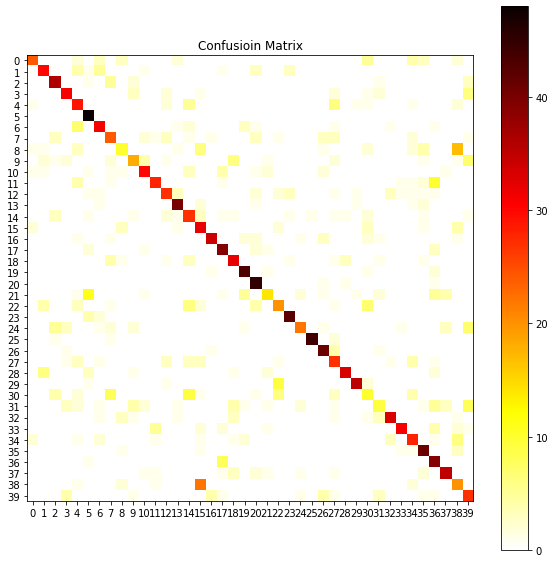

Accuracy of each class:
 tensor([0.5000, 0.6250, 0.7500, 0.6458, 0.6042, 1.0000, 0.6458, 0.5000, 0.2083,
        0.3750, 0.6250, 0.5833, 0.5625, 0.8333, 0.5625, 0.6667, 0.7083, 0.8125,
        0.6667, 0.8958, 0.9375, 0.2917, 0.4167, 0.8750, 0.4583, 0.9167, 0.8542,
        0.5625, 0.6875, 0.7292, 0.2083, 0.1875, 0.6875, 0.6458, 0.5833, 0.8542,
        0.8125, 0.7292, 0.4167, 0.5625])
Recall of each class:
 tensor([0.7742, 0.6818, 0.6792, 0.6889, 0.4603, 0.6400, 0.6327, 0.4800, 0.4167,
        0.5455, 0.7143, 0.7568, 0.6429, 0.7843, 0.4576, 0.4211, 0.8293, 0.6610,
        0.6275, 0.7544, 0.6716, 0.5833, 0.4878, 0.8400, 0.7586, 0.9778, 0.7193,
        0.4655, 0.8684, 0.8974, 0.2703, 0.3913, 0.8049, 0.8857, 0.5490, 0.6721,
        0.5132, 0.7609, 0.3390, 0.4426])
Epoch 13/40: , lr = 0.12
Step [10/60] Train Loss: 0.2685
Step [20/60] Train Loss: 0.3973
Step [30/60] Train Loss: 0.3088
Step [40/60] Train Loss: 0.3049
Step [50/60] Train Loss: 0.3466
Step [60/60] Train Loss: 0.2030
Accuracy on T

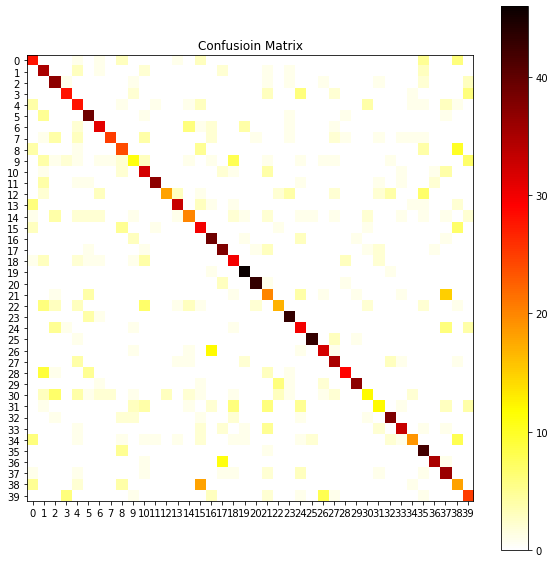

Accuracy of each class:
 tensor([0.5833, 0.7292, 0.7708, 0.5833, 0.5833, 0.8125, 0.6458, 0.5208, 0.5000,
        0.2292, 0.6667, 0.7708, 0.3750, 0.6875, 0.4167, 0.6250, 0.8125, 0.7917,
        0.6250, 0.9583, 0.8958, 0.4167, 0.3542, 0.8958, 0.6250, 0.8958, 0.6667,
        0.7292, 0.6042, 0.7708, 0.2500, 0.2500, 0.7917, 0.6875, 0.3958, 0.8750,
        0.7292, 0.7500, 0.3750, 0.5208])
Recall of each class:
 tensor([0.4746, 0.4730, 0.5781, 0.7368, 0.4590, 0.6724, 0.7045, 0.8929, 0.4898,
        0.3929, 0.5246, 0.9250, 0.8571, 0.8049, 0.5556, 0.4167, 0.6190, 0.6441,
        0.5455, 0.8214, 0.9149, 0.3636, 0.5862, 0.7818, 0.5172, 0.9348, 0.6957,
        0.6863, 0.8286, 0.9250, 0.5217, 0.5000, 0.7755, 0.8049, 0.7308, 0.5833,
        0.8974, 0.5000, 0.3333, 0.4902])
Epoch 14/40: , lr = 0.12
Step [10/60] Train Loss: 0.2065
Step [20/60] Train Loss: 0.2397
Step [30/60] Train Loss: 0.3569
Step [40/60] Train Loss: 0.3331
Step [50/60] Train Loss: 0.2502
Step [60/60] Train Loss: 0.2864
Accuracy on T

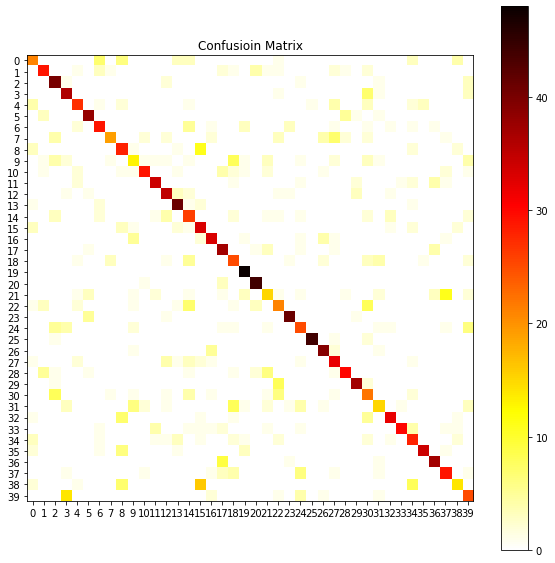

Accuracy of each class:
 tensor([0.4375, 0.6042, 0.8333, 0.7500, 0.5625, 0.7917, 0.6042, 0.3958, 0.5833,
        0.2708, 0.6042, 0.7083, 0.7292, 0.8542, 0.5417, 0.6875, 0.6875, 0.7708,
        0.5208, 1.0000, 0.9167, 0.3125, 0.4375, 0.8542, 0.5208, 0.9167, 0.8125,
        0.6667, 0.6250, 0.7708, 0.4583, 0.3125, 0.6667, 0.6250, 0.5833, 0.7083,
        0.7708, 0.6042, 0.2917, 0.5208])
Recall of each class:
 tensor([0.5000, 0.6905, 0.5970, 0.5806, 0.6585, 0.7755, 0.6170, 0.7600, 0.4667,
        0.3939, 0.8056, 0.7907, 0.6604, 0.7193, 0.4194, 0.4783, 0.7021, 0.5968,
        0.4386, 0.7742, 0.8148, 0.4167, 0.4468, 0.8542, 0.5208, 0.9778, 0.7500,
        0.5714, 0.7692, 0.8409, 0.3438, 0.5000, 0.8000, 0.9375, 0.5000, 0.8947,
        0.7551, 0.6042, 0.5385, 0.4808])
Epoch 15/40: , lr = 0.12
Step [10/60] Train Loss: 0.1686
Step [20/60] Train Loss: 0.1247
Step [30/60] Train Loss: 0.3358
Step [40/60] Train Loss: 0.3459
Step [50/60] Train Loss: 0.3401
Step [60/60] Train Loss: 0.2615
Accuracy on T

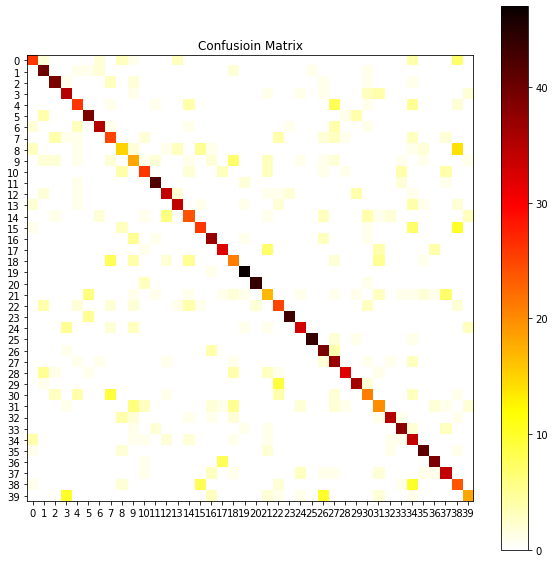

Accuracy of each class:
 tensor([0.5417, 0.8333, 0.8125, 0.7292, 0.5417, 0.8125, 0.7292, 0.5208, 0.3125,
        0.3750, 0.5417, 0.8750, 0.7083, 0.7083, 0.5000, 0.5417, 0.7708, 0.6667,
        0.4375, 0.9792, 0.9167, 0.3542, 0.5208, 0.8958, 0.6875, 0.9167, 0.8125,
        0.7708, 0.6667, 0.7500, 0.4375, 0.4167, 0.7292, 0.7917, 0.7083, 0.8542,
        0.8125, 0.7083, 0.5000, 0.3750])
Recall of each class:
 tensor([0.6500, 0.6667, 0.7800, 0.6481, 0.6047, 0.7500, 0.8333, 0.4717, 0.4545,
        0.3673, 0.6500, 0.8571, 0.7234, 0.7907, 0.5333, 0.6341, 0.6852, 0.7111,
        0.4565, 0.8704, 0.9565, 0.3953, 0.5102, 0.9348, 0.7857, 0.9778, 0.6094,
        0.5441, 0.8889, 0.7826, 0.5122, 0.4651, 0.8750, 0.7755, 0.4198, 0.8367,
        0.8298, 0.6538, 0.3750, 0.6207])
Epoch 16/40: , lr = 0.12
Step [10/60] Train Loss: 0.2365
Step [20/60] Train Loss: 0.2590
Step [30/60] Train Loss: 0.2105
Step [40/60] Train Loss: 0.1626
Step [50/60] Train Loss: 0.3119
Step [60/60] Train Loss: 0.3049
Accuracy on T

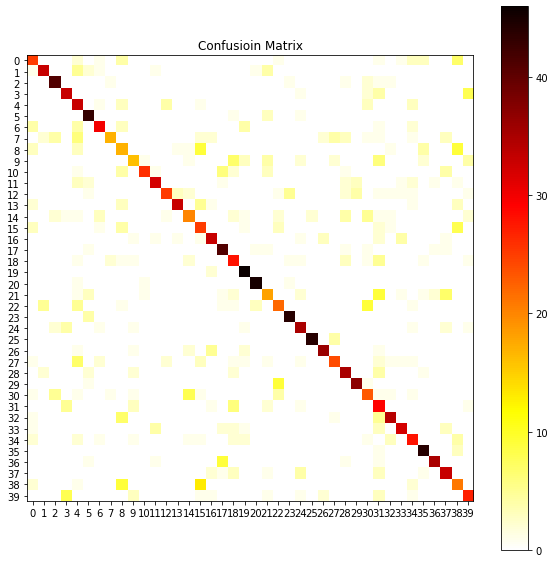

Accuracy of each class:
 tensor([0.5208, 0.6875, 0.8542, 0.6875, 0.6875, 0.8958, 0.6250, 0.3542, 0.3542,
        0.3333, 0.5417, 0.6667, 0.5208, 0.6875, 0.4167, 0.5208, 0.6875, 0.8542,
        0.5833, 0.9583, 0.9375, 0.3750, 0.4583, 0.9167, 0.7292, 0.9167, 0.7500,
        0.5000, 0.7292, 0.7708, 0.4792, 0.6042, 0.7083, 0.6667, 0.5833, 0.9167,
        0.7292, 0.6875, 0.4375, 0.5625])
Recall of each class:
 tensor([0.5435, 0.7857, 0.7593, 0.6471, 0.4231, 0.7167, 0.7317, 0.8095, 0.3036,
        0.5333, 0.8966, 0.8000, 0.7812, 0.8684, 0.5405, 0.4032, 0.7021, 0.6613,
        0.4746, 0.7419, 0.9000, 0.4737, 0.5238, 0.8462, 0.7000, 0.9565, 0.8372,
        0.6857, 0.6604, 0.8409, 0.4694, 0.3333, 0.7727, 0.7805, 0.5833, 0.7719,
        0.8974, 0.6111, 0.3750, 0.6000])
Epoch 17/40: , lr = 0.12
Step [10/60] Train Loss: 0.1984
Step [20/60] Train Loss: 0.3357
Step [30/60] Train Loss: 0.2829
Step [40/60] Train Loss: 0.2259
Step [50/60] Train Loss: 0.1619
Step [60/60] Train Loss: 0.5045
Accuracy on T

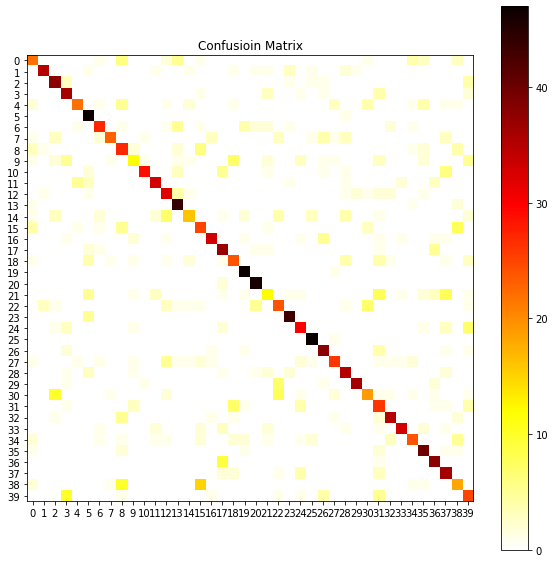

Accuracy of each class:
 tensor([0.4583, 0.7292, 0.7917, 0.7500, 0.4583, 0.9792, 0.5625, 0.4792, 0.5625,
        0.2500, 0.6042, 0.6875, 0.6667, 0.9167, 0.3333, 0.5208, 0.6875, 0.7708,
        0.5000, 0.9792, 0.9583, 0.2500, 0.5000, 0.8958, 0.6250, 0.9792, 0.7917,
        0.5417, 0.7292, 0.7500, 0.3958, 0.5417, 0.7292, 0.6875, 0.5000, 0.8333,
        0.7917, 0.7500, 0.3750, 0.5208])
Recall of each class:
 tensor([0.5238, 0.8750, 0.6441, 0.5714, 0.7333, 0.6438, 0.7105, 0.8519, 0.4286,
        0.5000, 0.9062, 0.7857, 0.5714, 0.6667, 0.6400, 0.4464, 0.8250, 0.5781,
        0.5333, 0.7833, 0.8214, 0.4286, 0.5000, 0.8269, 0.6122, 0.8393, 0.6786,
        0.7222, 0.6481, 0.9231, 0.5429, 0.3714, 0.7778, 0.8684, 0.6667, 0.6897,
        0.7037, 0.5538, 0.4091, 0.4464])
Epoch 18/40: , lr = 0.12
Step [10/60] Train Loss: 0.1655
Step [20/60] Train Loss: 0.2261
Step [30/60] Train Loss: 0.2343
Step [40/60] Train Loss: 0.4540
Step [50/60] Train Loss: 0.1476
Step [60/60] Train Loss: 0.2508
Accuracy on T

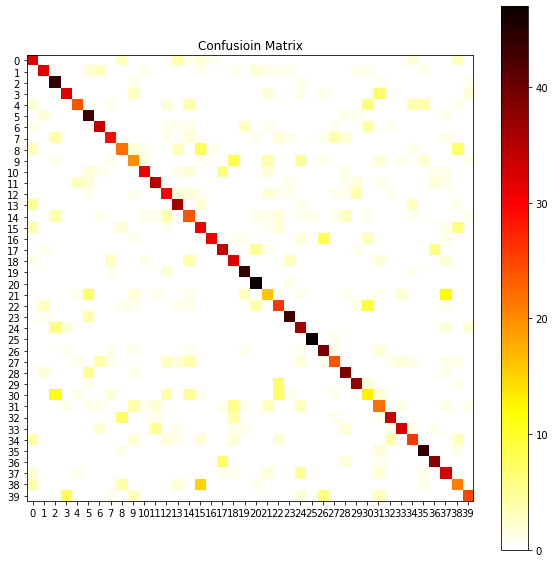

Accuracy of each class:
 tensor([0.6667, 0.6667, 0.9167, 0.6667, 0.5000, 0.8958, 0.7083, 0.6042, 0.4583,
        0.4167, 0.6458, 0.7292, 0.6250, 0.7500, 0.5000, 0.6458, 0.6458, 0.7083,
        0.6667, 0.9167, 0.9792, 0.3333, 0.5417, 0.8958, 0.7500, 0.9792, 0.8125,
        0.5000, 0.8125, 0.7708, 0.2708, 0.4583, 0.7083, 0.6875, 0.5417, 0.9167,
        0.7917, 0.6875, 0.4375, 0.5208])
Recall of each class:
 tensor([0.5517, 0.7805, 0.6286, 0.7273, 0.7742, 0.6324, 0.7391, 0.7250, 0.5500,
        0.4762, 0.8378, 0.7778, 0.6000, 0.6667, 0.4615, 0.4844, 0.9394, 0.6939,
        0.5818, 0.8148, 0.7705, 0.4444, 0.5200, 0.8269, 0.5902, 0.9792, 0.6842,
        0.6857, 0.7358, 0.7872, 0.3333, 0.4490, 0.8095, 0.8462, 0.6500, 0.8302,
        0.7917, 0.5593, 0.4667, 0.7576])
Epoch 19/40: , lr = 0.12
Step [10/60] Train Loss: 0.2483
Step [20/60] Train Loss: 0.2072
Step [30/60] Train Loss: 0.2439
Step [40/60] Train Loss: 0.1949
Step [50/60] Train Loss: 0.4045
Step [60/60] Train Loss: 0.1544
Accuracy on T

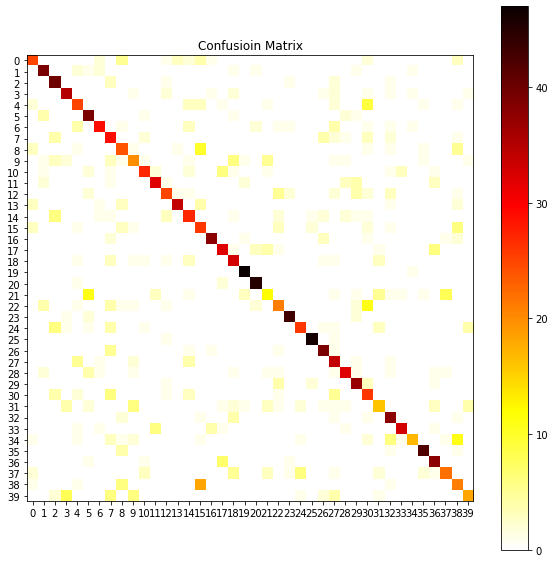

Accuracy of each class:
 tensor([0.5208, 0.8125, 0.8333, 0.7292, 0.5208, 0.8125, 0.6042, 0.6042, 0.5000,
        0.4167, 0.5625, 0.6667, 0.5208, 0.7083, 0.5625, 0.5417, 0.7917, 0.6667,
        0.6875, 0.9792, 0.9375, 0.2500, 0.4375, 0.8958, 0.5417, 0.9583, 0.8125,
        0.7083, 0.6667, 0.7708, 0.5417, 0.3333, 0.7917, 0.6875, 0.3542, 0.8750,
        0.7917, 0.4583, 0.4375, 0.3750])
Recall of each class:
 tensor([0.6250, 0.7358, 0.6154, 0.6863, 0.5435, 0.6000, 0.7632, 0.4085, 0.4706,
        0.4762, 0.7297, 0.7442, 0.6579, 0.8718, 0.5294, 0.3881, 0.8444, 0.6400,
        0.5690, 0.8545, 0.8491, 0.4000, 0.5122, 0.8776, 0.7222, 0.9020, 0.7222,
        0.5075, 0.7442, 0.6727, 0.3939, 0.5161, 0.6230, 0.8684, 0.8095, 0.8750,
        0.6909, 0.6667, 0.3818, 0.6429])
Epoch 20/40: , lr = 0.12
Step [10/60] Train Loss: 0.2807
Step [20/60] Train Loss: 0.2269
Step [30/60] Train Loss: 0.2556
Step [40/60] Train Loss: 0.2254
Step [50/60] Train Loss: 0.0996
Step [60/60] Train Loss: 0.3721
Accuracy on T

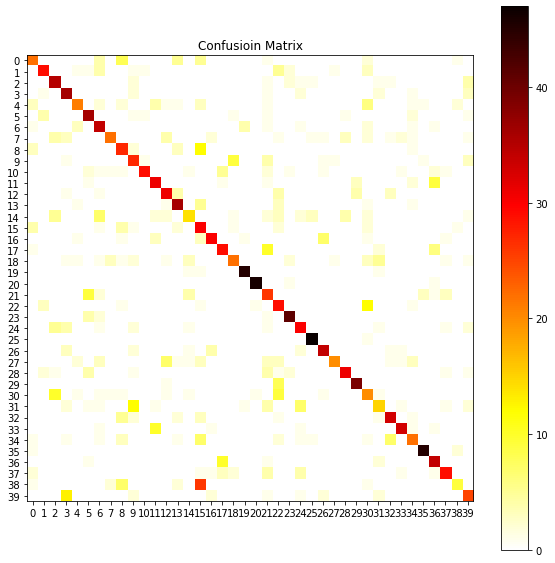

Accuracy of each class:
 tensor([0.4583, 0.6042, 0.7292, 0.7500, 0.4375, 0.7500, 0.7083, 0.4583, 0.5625,
        0.5625, 0.6042, 0.6458, 0.6458, 0.7500, 0.2917, 0.6250, 0.6250, 0.6042,
        0.4583, 0.9375, 0.9583, 0.5417, 0.6042, 0.8542, 0.6250, 0.9792, 0.7083,
        0.4167, 0.6458, 0.8125, 0.4167, 0.3125, 0.6875, 0.6875, 0.4583, 0.9375,
        0.7083, 0.6042, 0.1875, 0.5208])
Recall of each class:
 tensor([0.5641, 0.7436, 0.5833, 0.5538, 0.6774, 0.6102, 0.5075, 0.7586, 0.4426,
        0.4576, 0.9062, 0.6078, 0.6327, 0.6316, 0.5185, 0.3000, 0.7500, 0.6042,
        0.6111, 0.8824, 0.9583, 0.3714, 0.4085, 0.8039, 0.5769, 0.8868, 0.7234,
        0.8696, 0.7949, 0.8478, 0.3390, 0.4545, 0.7021, 0.8250, 0.5789, 0.9000,
        0.6071, 0.7632, 0.6000, 0.5682])
Epoch 21/40: , lr = 0.072
Step [10/60] Train Loss: 0.1892
Step [20/60] Train Loss: 0.1469
Step [30/60] Train Loss: 0.0875
Step [40/60] Train Loss: 0.1813
Step [50/60] Train Loss: 0.1176
Step [60/60] Train Loss: 0.3018
Accuracy on 

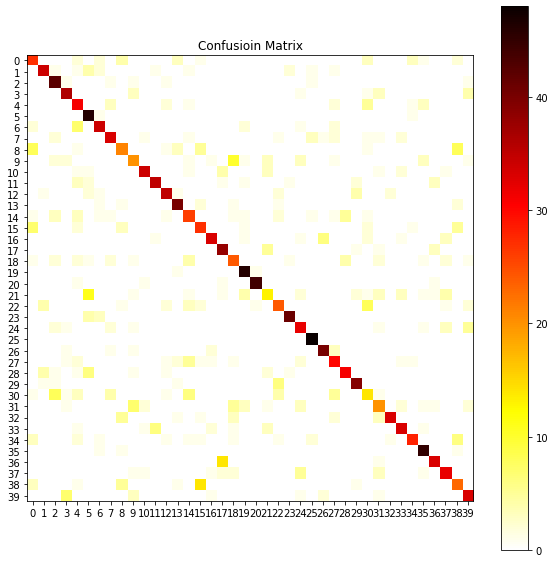

Accuracy of each class:
 tensor([0.5625, 0.7083, 0.8750, 0.7500, 0.6458, 0.9583, 0.7083, 0.6875, 0.4375,
        0.4167, 0.7083, 0.7292, 0.7292, 0.8333, 0.5417, 0.5625, 0.6875, 0.7917,
        0.5000, 0.9583, 0.9167, 0.2708, 0.5000, 0.8542, 0.6667, 1.0000, 0.8333,
        0.6250, 0.6458, 0.8125, 0.2917, 0.4167, 0.6875, 0.6875, 0.5833, 0.9375,
        0.6875, 0.6667, 0.4792, 0.6875])
Recall of each class:
 tensor([0.5094, 0.7727, 0.6562, 0.7059, 0.4844, 0.5974, 0.7234, 0.7021, 0.5122,
        0.5000, 0.8500, 0.8140, 0.7609, 0.7547, 0.5098, 0.5000, 0.8049, 0.6230,
        0.4898, 0.7667, 0.9565, 0.4333, 0.5854, 0.8913, 0.6275, 0.8571, 0.8163,
        0.6122, 0.7750, 0.7959, 0.3590, 0.4878, 0.9167, 0.7500, 0.8000, 0.7759,
        0.7857, 0.6957, 0.4894, 0.6735])
Epoch 22/40: , lr = 0.072
Step [10/60] Train Loss: 0.2446
Step [20/60] Train Loss: 0.1531
Step [30/60] Train Loss: 0.2851
Step [40/60] Train Loss: 0.1719
Step [50/60] Train Loss: 0.0940
Step [60/60] Train Loss: 0.1269
Accuracy on 

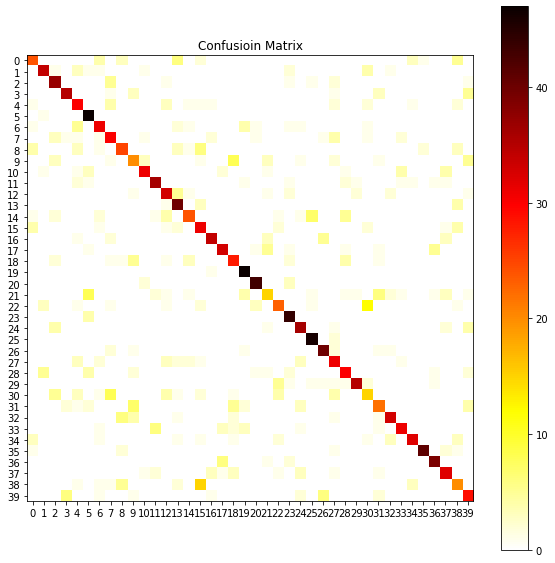

Accuracy of each class:
 tensor([0.5000, 0.7083, 0.7708, 0.7292, 0.6250, 0.9792, 0.6458, 0.6250, 0.5208,
        0.4167, 0.6458, 0.7500, 0.6875, 0.8333, 0.5000, 0.6458, 0.7083, 0.6875,
        0.5833, 0.9792, 0.8958, 0.3125, 0.4792, 0.9167, 0.7500, 0.9583, 0.8333,
        0.6458, 0.6250, 0.7292, 0.3125, 0.4583, 0.6875, 0.6458, 0.6667, 0.8542,
        0.8125, 0.6667, 0.4167, 0.6042])
Recall of each class:
 tensor([0.6154, 0.7727, 0.6491, 0.7955, 0.5455, 0.6620, 0.6458, 0.5357, 0.5952,
        0.4545, 0.7949, 0.7660, 0.6226, 0.6154, 0.7059, 0.4769, 0.8095, 0.7333,
        0.5600, 0.7581, 0.8600, 0.4839, 0.6053, 0.7097, 0.7059, 0.8070, 0.7547,
        0.5636, 0.6667, 0.8974, 0.3750, 0.5500, 0.7857, 0.7750, 0.8000, 0.9318,
        0.8125, 0.6667, 0.4651, 0.5577])
Epoch 23/40: , lr = 0.072
Step [10/60] Train Loss: 0.2118
Step [20/60] Train Loss: 0.1302
Step [30/60] Train Loss: 0.1819
Step [40/60] Train Loss: 0.1766
Step [50/60] Train Loss: 0.1910
Step [60/60] Train Loss: 0.1717
Accuracy on 

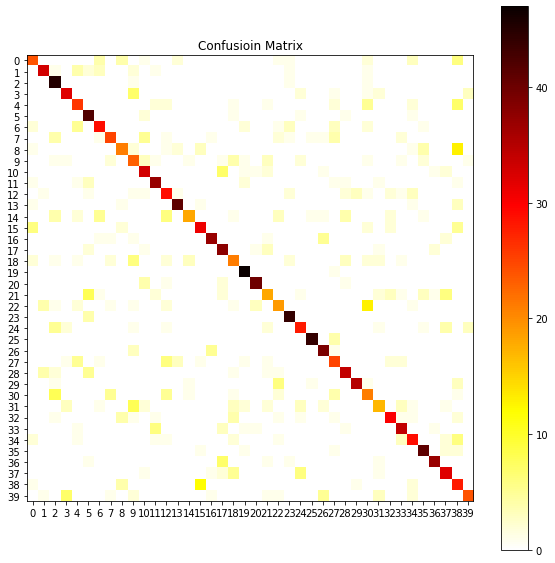

Accuracy of each class:
 tensor([0.5000, 0.6875, 0.9375, 0.6667, 0.5417, 0.8750, 0.6042, 0.5208, 0.4375,
        0.4792, 0.6875, 0.7708, 0.6042, 0.8542, 0.3750, 0.6458, 0.7708, 0.7917,
        0.4375, 0.9792, 0.8333, 0.3750, 0.3958, 0.9167, 0.5833, 0.9167, 0.8125,
        0.5208, 0.7083, 0.7292, 0.4375, 0.3542, 0.6250, 0.7083, 0.6042, 0.8542,
        0.7708, 0.6667, 0.5833, 0.5000])
Recall of each class:
 tensor([0.6000, 0.7674, 0.6081, 0.6957, 0.5417, 0.6176, 0.6304, 0.6757, 0.5833,
        0.3898, 0.6226, 0.7255, 0.5088, 0.8367, 0.7500, 0.6327, 0.8222, 0.6129,
        0.4667, 0.8103, 0.8696, 0.5000, 0.5000, 0.7857, 0.6364, 0.9362, 0.7222,
        0.5208, 0.7234, 0.8974, 0.3962, 0.5484, 0.7317, 0.6939, 0.6170, 0.7736,
        0.8810, 0.6275, 0.3636, 0.7742])
Epoch 24/40: , lr = 0.072
Step [10/60] Train Loss: 0.2188
Step [20/60] Train Loss: 0.1705
Step [30/60] Train Loss: 0.1695
Step [40/60] Train Loss: 0.1960
Step [50/60] Train Loss: 0.1070
Step [60/60] Train Loss: 0.1143
Accuracy on 

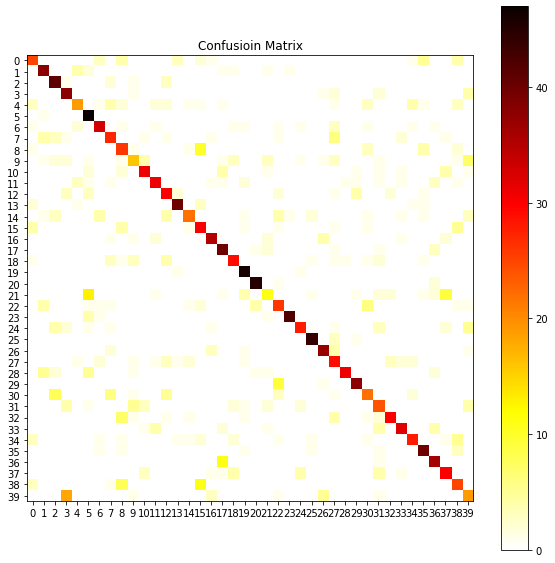

Accuracy of each class:
 tensor([0.5208, 0.7917, 0.8542, 0.7917, 0.3958, 0.9792, 0.6875, 0.5625, 0.5417,
        0.3333, 0.6458, 0.6458, 0.6250, 0.8333, 0.4583, 0.6250, 0.7292, 0.8333,
        0.6042, 0.9583, 0.9375, 0.2292, 0.5417, 0.8750, 0.5833, 0.9167, 0.7708,
        0.6042, 0.6458, 0.7917, 0.4583, 0.5000, 0.6250, 0.6667, 0.5833, 0.8333,
        0.7500, 0.6250, 0.5208, 0.3958])
Recall of each class:
 tensor([0.5814, 0.7037, 0.6508, 0.5507, 0.6333, 0.5802, 0.7021, 0.5510, 0.4483,
        0.4848, 0.7209, 0.7381, 0.5660, 0.8333, 0.7333, 0.4918, 0.7609, 0.6349,
        0.6905, 0.7667, 0.8824, 0.4400, 0.5200, 0.9545, 0.7568, 0.8800, 0.7551,
        0.4754, 0.9394, 0.8261, 0.5500, 0.4800, 0.8108, 0.7805, 0.7179, 0.7273,
        0.6792, 0.6122, 0.5000, 0.4222])
Epoch 25/40: , lr = 0.072
Step [10/60] Train Loss: 0.1577
Step [20/60] Train Loss: 0.1477
Step [30/60] Train Loss: 0.1904
Step [40/60] Train Loss: 0.0861
Step [50/60] Train Loss: 0.1820
Step [60/60] Train Loss: 0.1314
Accuracy on 

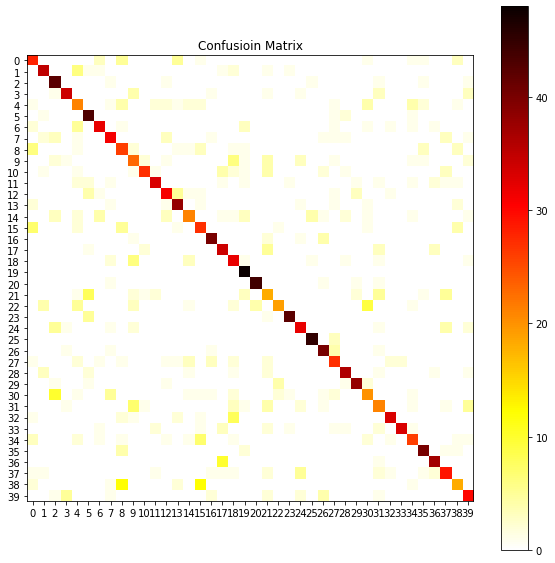

Accuracy of each class:
 tensor([0.5833, 0.7292, 0.8750, 0.7083, 0.4375, 0.8958, 0.6667, 0.6458, 0.5417,
        0.4792, 0.5625, 0.6875, 0.6458, 0.7917, 0.4375, 0.5625, 0.8333, 0.7083,
        0.6667, 1.0000, 0.9167, 0.3750, 0.3958, 0.8750, 0.6667, 0.9375, 0.8333,
        0.5625, 0.7500, 0.7917, 0.4167, 0.4375, 0.6875, 0.6875, 0.5417, 0.8333,
        0.7708, 0.6042, 0.3750, 0.6250])
Recall of each class:
 tensor([0.5185, 0.7447, 0.6176, 0.7907, 0.4038, 0.6418, 0.7273, 0.6596, 0.4262,
        0.4423, 0.8182, 0.8049, 0.6889, 0.6786, 0.6000, 0.4737, 0.8000, 0.6182,
        0.5000, 0.7385, 0.9167, 0.3600, 0.7308, 0.9130, 0.6809, 0.8824, 0.7273,
        0.6136, 0.8000, 0.8444, 0.4762, 0.4667, 0.8462, 0.9429, 0.6341, 0.8000,
        0.8043, 0.6170, 0.5294, 0.6250])
Epoch 26/40: , lr = 0.072
Step [10/60] Train Loss: 0.2112
Step [20/60] Train Loss: 0.1213
Step [30/60] Train Loss: 0.1651
Step [40/60] Train Loss: 0.1463
Step [50/60] Train Loss: 0.1929
Step [60/60] Train Loss: 0.1324
Accuracy on 

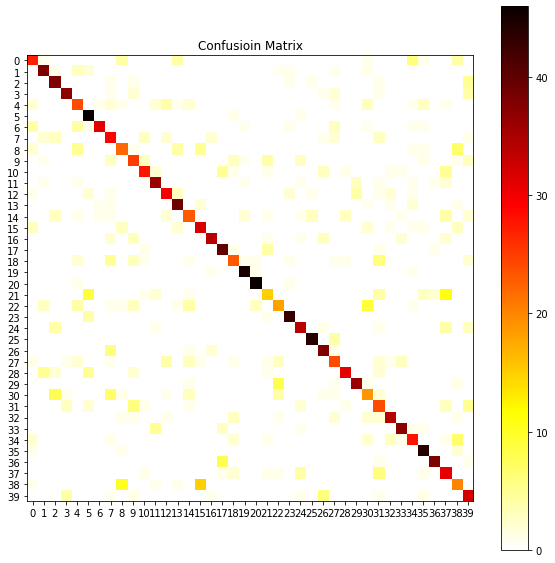

Accuracy of each class:
 tensor([0.5625, 0.7917, 0.7917, 0.7708, 0.5000, 0.9583, 0.6458, 0.6042, 0.4583,
        0.5208, 0.5833, 0.7500, 0.6250, 0.8125, 0.4792, 0.6667, 0.7083, 0.8333,
        0.4792, 0.9375, 0.9583, 0.3125, 0.3750, 0.8958, 0.7083, 0.9167, 0.7917,
        0.5000, 0.6458, 0.7500, 0.3958, 0.5000, 0.7083, 0.7708, 0.5833, 0.9167,
        0.7917, 0.6458, 0.4167, 0.6667])
Recall of each class:
 tensor([0.6136, 0.7451, 0.6441, 0.8043, 0.5106, 0.6479, 0.9118, 0.4603, 0.5000,
        0.5208, 0.7179, 0.7347, 0.6818, 0.7091, 0.5750, 0.5818, 0.8500, 0.7018,
        0.6216, 0.8824, 0.9020, 0.4839, 0.5000, 0.8600, 0.6939, 0.8980, 0.7037,
        0.5581, 0.8378, 0.8372, 0.4524, 0.4068, 0.7907, 0.8222, 0.6222, 0.7586,
        0.9048, 0.4844, 0.4255, 0.5517])
Epoch 27/40: , lr = 0.072
Step [10/60] Train Loss: 0.1445
Step [20/60] Train Loss: 0.1728
Step [30/60] Train Loss: 0.1667
Step [40/60] Train Loss: 0.0720
Step [50/60] Train Loss: 0.2124
Step [60/60] Train Loss: 0.1699
Accuracy on 

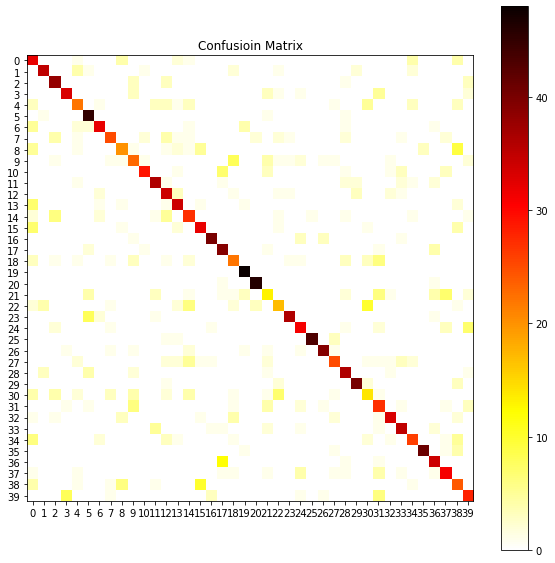

Accuracy of each class:
 tensor([0.6667, 0.7292, 0.7917, 0.6875, 0.4583, 0.9375, 0.6667, 0.5208, 0.4167,
        0.4792, 0.6042, 0.7500, 0.7083, 0.7083, 0.5625, 0.6667, 0.8333, 0.8125,
        0.4583, 1.0000, 0.9583, 0.2708, 0.3542, 0.7500, 0.6458, 0.8958, 0.8125,
        0.5208, 0.7500, 0.8333, 0.2917, 0.5625, 0.6875, 0.7292, 0.5417, 0.8542,
        0.7083, 0.6458, 0.5000, 0.5833])
Recall of each class:
 tensor([0.3902, 0.8140, 0.6667, 0.7674, 0.5641, 0.6716, 0.7619, 0.7143, 0.5556,
        0.4894, 0.8529, 0.7200, 0.5484, 0.6538, 0.5000, 0.6400, 0.8696, 0.6190,
        0.5000, 0.8276, 0.9020, 0.3514, 0.5000, 0.9000, 0.6596, 0.9773, 0.8667,
        0.6944, 0.6792, 0.8511, 0.3684, 0.4355, 0.8049, 0.7292, 0.6500, 0.9318,
        0.6800, 0.6327, 0.3934, 0.5714])
Epoch 28/40: , lr = 0.072
Step [10/60] Train Loss: 0.0883
Step [20/60] Train Loss: 0.3009
Step [30/60] Train Loss: 0.2769
Step [40/60] Train Loss: 0.0593
Step [50/60] Train Loss: 0.1123
Step [60/60] Train Loss: 0.1740
Accuracy on 

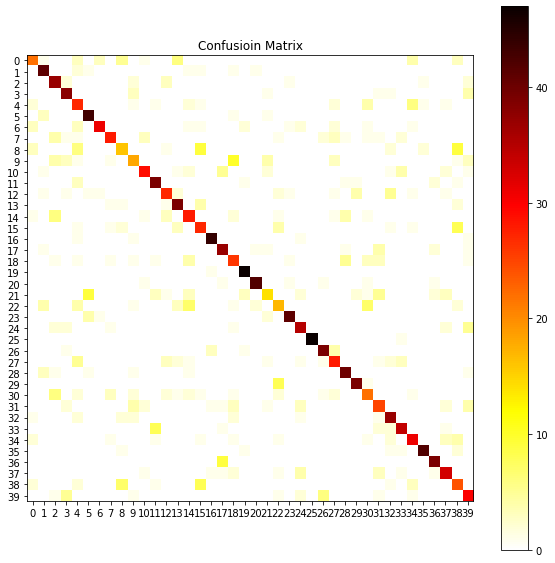

Accuracy of each class:
 tensor([0.4583, 0.8542, 0.7708, 0.7917, 0.5625, 0.8958, 0.6458, 0.5833, 0.3333,
        0.3750, 0.6042, 0.8125, 0.5625, 0.8125, 0.5833, 0.5625, 0.9167, 0.7708,
        0.5417, 0.9792, 0.8750, 0.2917, 0.3542, 0.8542, 0.7292, 0.9792, 0.8125,
        0.5833, 0.8333, 0.8125, 0.4583, 0.5208, 0.7708, 0.7083, 0.6458, 0.8750,
        0.8125, 0.6875, 0.5000, 0.6250])
Recall of each class:
 tensor([0.6111, 0.7455, 0.5968, 0.6909, 0.4219, 0.7288, 0.8611, 0.7568, 0.4706,
        0.4865, 0.7632, 0.7222, 0.6585, 0.6842, 0.5385, 0.5094, 0.8800, 0.6727,
        0.5098, 0.8545, 0.9130, 0.5185, 0.4474, 0.8913, 0.6863, 1.0000, 0.7800,
        0.6087, 0.7692, 0.8478, 0.5116, 0.5319, 0.6727, 0.7391, 0.6327, 0.9130,
        0.8298, 0.6875, 0.4286, 0.5660])
Epoch 29/40: , lr = 0.072
Step [10/60] Train Loss: 0.1049
Step [20/60] Train Loss: 0.2521
Step [30/60] Train Loss: 0.2154
Step [40/60] Train Loss: 0.1145
Step [50/60] Train Loss: 0.1659
Step [60/60] Train Loss: 0.1454
Accuracy on 

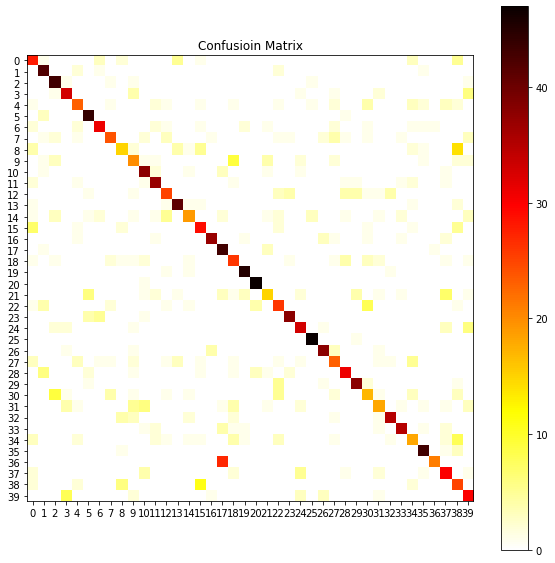

Accuracy of each class:
 tensor([0.5833, 0.8750, 0.8958, 0.6875, 0.4792, 0.9167, 0.6458, 0.5000, 0.3125,
        0.4167, 0.7917, 0.7708, 0.5208, 0.8542, 0.3958, 0.6042, 0.7708, 0.8958,
        0.5417, 0.9375, 0.9792, 0.3125, 0.5417, 0.7917, 0.6875, 0.9792, 0.7917,
        0.4792, 0.6458, 0.7917, 0.3542, 0.3750, 0.7292, 0.7292, 0.3750, 0.8958,
        0.4375, 0.6250, 0.5208, 0.6250])
Recall of each class:
 tensor([0.4828, 0.7000, 0.6719, 0.6600, 0.5897, 0.7458, 0.7209, 0.6857, 0.4839,
        0.4348, 0.6552, 0.7115, 0.6098, 0.7593, 0.6552, 0.5577, 0.8605, 0.5181,
        0.4906, 0.8491, 0.8704, 0.5556, 0.5098, 0.8261, 0.6600, 0.9038, 0.7917,
        0.5349, 0.7045, 0.7917, 0.4359, 0.5455, 0.8333, 0.8333, 0.4390, 0.8269,
        0.9130, 0.5556, 0.3521, 0.5263])
Epoch 30/40: , lr = 0.072
Step [10/60] Train Loss: 0.1772
Step [20/60] Train Loss: 0.2562
Step [30/60] Train Loss: 0.1278
Step [40/60] Train Loss: 0.1522
Step [50/60] Train Loss: 0.1590
Step [60/60] Train Loss: 0.2036
Accuracy on 

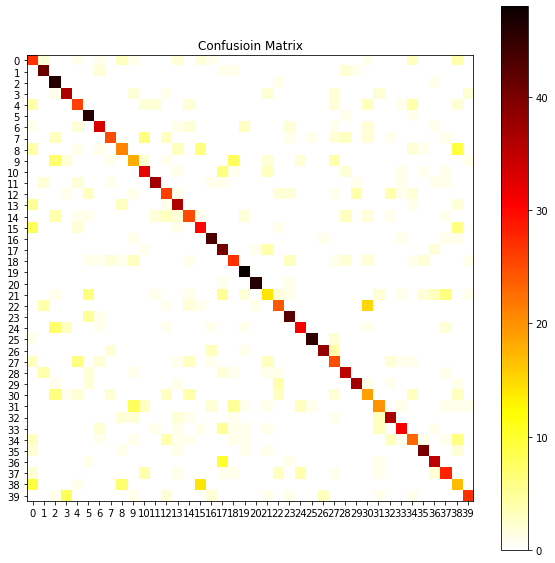

Accuracy of each class:
 tensor([0.5625, 0.8542, 0.9583, 0.7500, 0.5417, 0.9583, 0.6875, 0.5208, 0.4375,
        0.3750, 0.6667, 0.7708, 0.5417, 0.7500, 0.5208, 0.6250, 0.8958, 0.8333,
        0.5625, 1.0000, 0.9583, 0.2917, 0.5000, 0.8750, 0.6458, 0.9375, 0.7917,
        0.5208, 0.7292, 0.7708, 0.3958, 0.4167, 0.7500, 0.6458, 0.4792, 0.8333,
        0.7292, 0.5833, 0.3542, 0.5625])
Recall of each class:
 tensor([0.3913, 0.7736, 0.5974, 0.7059, 0.5909, 0.6866, 0.7333, 0.7576, 0.5526,
        0.4615, 0.6400, 0.8605, 0.5652, 0.6545, 0.5952, 0.5455, 0.7963, 0.5556,
        0.5745, 0.7869, 0.9583, 0.4242, 0.5854, 0.7778, 0.7750, 0.9574, 0.9048,
        0.5208, 0.7292, 0.8605, 0.3958, 0.6061, 0.7500, 0.7750, 0.5476, 0.8511,
        0.7609, 0.6364, 0.3148, 0.8182])
Epoch 31/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.1784
Step [20/60] Train Loss: 0.1594
Step [30/60] Train Loss: 0.1651
Step [40/60] Train Loss: 0.1640
Step [50/60] Train Loss: 0.0759
Step [60/60] Train Loss: 0.07

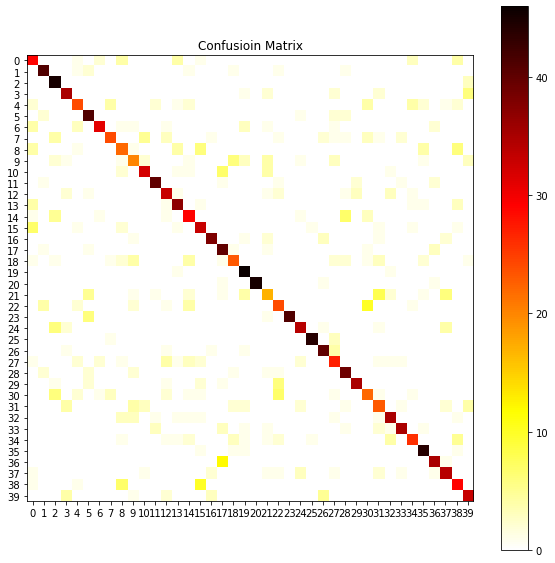

Accuracy of each class:
 tensor([0.6042, 0.8542, 0.9375, 0.7292, 0.5000, 0.8542, 0.6458, 0.5000, 0.4583,
        0.4167, 0.6667, 0.8333, 0.6875, 0.7708, 0.6042, 0.6875, 0.7917, 0.8333,
        0.4792, 0.9583, 0.9375, 0.3542, 0.5000, 0.8542, 0.7083, 0.9167, 0.8333,
        0.5625, 0.8125, 0.7292, 0.4583, 0.4792, 0.7292, 0.7292, 0.5417, 0.9167,
        0.7292, 0.7083, 0.6042, 0.6875])
Recall of each class:
 tensor([0.5273, 0.8039, 0.6429, 0.7143, 0.6316, 0.6833, 0.8378, 0.7273, 0.4783,
        0.5000, 0.7442, 0.8511, 0.6471, 0.6981, 0.5686, 0.5690, 0.8444, 0.5970,
        0.6053, 0.7188, 1.0000, 0.4595, 0.5217, 1.0000, 0.7727, 0.9565, 0.7692,
        0.5625, 0.7091, 0.8750, 0.5000, 0.4894, 0.7292, 0.8537, 0.6842, 0.7857,
        0.7955, 0.6800, 0.5577, 0.6600])
Epoch 32/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.0836
Step [20/60] Train Loss: 0.1771
Step [30/60] Train Loss: 0.1729
Step [40/60] Train Loss: 0.1600
Step [50/60] Train Loss: 0.1427
Step [60/60] Train Loss: 0.12

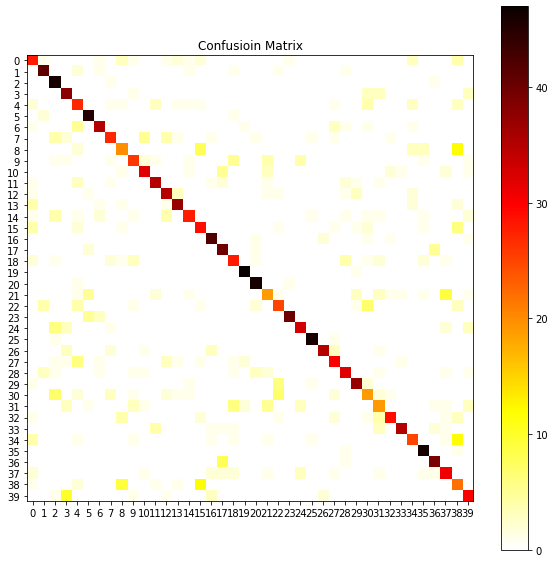

Accuracy of each class:
 tensor([0.5833, 0.8542, 0.9583, 0.7917, 0.5625, 0.9375, 0.7292, 0.5625, 0.4167,
        0.5417, 0.6667, 0.7292, 0.7292, 0.7708, 0.5833, 0.6042, 0.8750, 0.8333,
        0.5833, 0.9792, 0.9583, 0.3958, 0.5208, 0.8333, 0.6875, 0.9583, 0.7292,
        0.6250, 0.6667, 0.7708, 0.3958, 0.3958, 0.6042, 0.7292, 0.5208, 0.9583,
        0.8125, 0.6458, 0.4583, 0.6250])
Recall of each class:
 tensor([0.5283, 0.8039, 0.6301, 0.6230, 0.4576, 0.7627, 0.7778, 0.6923, 0.4878,
        0.6500, 0.7442, 0.7609, 0.6863, 0.7872, 0.7778, 0.5179, 0.7778, 0.6897,
        0.5957, 0.9038, 0.8364, 0.5135, 0.5814, 0.9524, 0.7674, 0.9200, 0.8974,
        0.6667, 0.7273, 0.7872, 0.4524, 0.4634, 0.8286, 0.9211, 0.6410, 0.8214,
        0.7959, 0.6200, 0.3235, 0.6522])
Epoch 33/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.1923
Step [20/60] Train Loss: 0.1606
Step [30/60] Train Loss: 0.0805
Step [40/60] Train Loss: 0.0553
Step [50/60] Train Loss: 0.1525
Step [60/60] Train Loss: 0.11

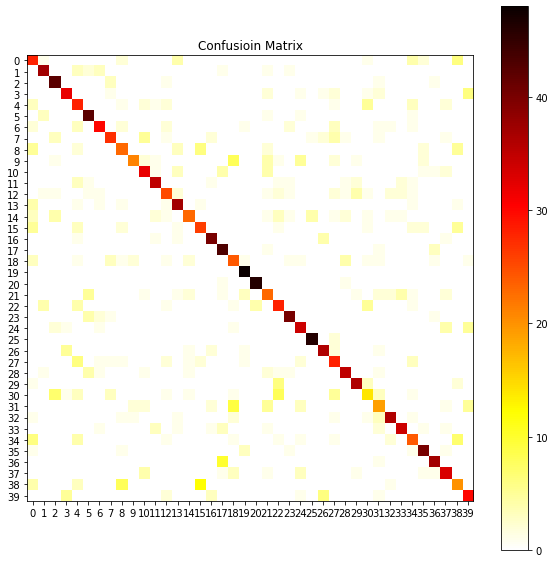

Accuracy of each class:
 tensor([0.5833, 0.7708, 0.8750, 0.6667, 0.5833, 0.8750, 0.6250, 0.5625, 0.4792,
        0.4375, 0.6667, 0.7292, 0.5208, 0.7708, 0.4792, 0.5417, 0.8333, 0.8958,
        0.5000, 1.0000, 0.9583, 0.4792, 0.5833, 0.8333, 0.7083, 0.9583, 0.7500,
        0.5833, 0.7292, 0.7500, 0.2917, 0.3958, 0.7500, 0.7083, 0.5000, 0.8333,
        0.7708, 0.6875, 0.4167, 0.6250])
Recall of each class:
 tensor([0.4242, 0.7872, 0.7000, 0.7273, 0.4308, 0.7119, 0.7317, 0.6923, 0.5349,
        0.8077, 0.6531, 0.7955, 0.6098, 0.6852, 0.7419, 0.5532, 0.7843, 0.6719,
        0.4800, 0.8276, 0.9200, 0.4694, 0.5385, 0.8163, 0.6538, 0.9020, 0.7347,
        0.5185, 0.7778, 0.8000, 0.4118, 0.4750, 0.8000, 0.7907, 0.5217, 0.7843,
        0.8222, 0.6875, 0.4348, 0.6383])
Epoch 34/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.0786
Step [20/60] Train Loss: 0.1207
Step [30/60] Train Loss: 0.1174
Step [40/60] Train Loss: 0.1688
Step [50/60] Train Loss: 0.1747
Step [60/60] Train Loss: 0.09

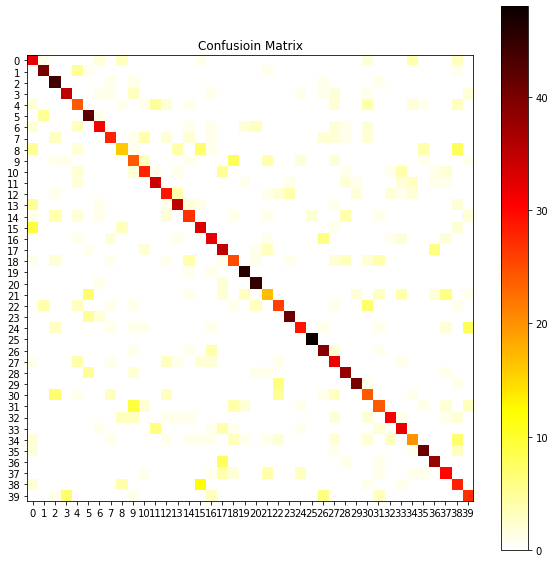

Accuracy of each class:
 tensor([0.6667, 0.8333, 0.9167, 0.7292, 0.5000, 0.8750, 0.6458, 0.5833, 0.3333,
        0.5000, 0.5833, 0.7083, 0.6042, 0.7292, 0.5625, 0.6875, 0.6667, 0.7292,
        0.5208, 0.9583, 0.9375, 0.3542, 0.5417, 0.8542, 0.6042, 1.0000, 0.8125,
        0.6667, 0.7917, 0.8333, 0.5000, 0.5000, 0.6458, 0.6667, 0.4167, 0.8542,
        0.7917, 0.6250, 0.5833, 0.5625])
Recall of each class:
 tensor([0.5000, 0.8000, 0.6667, 0.8140, 0.4898, 0.6885, 0.7561, 0.7000, 0.5333,
        0.4800, 0.6667, 0.7391, 0.6444, 0.7447, 0.6279, 0.5789, 0.6400, 0.5738,
        0.5556, 0.8364, 0.8333, 0.5000, 0.6190, 0.8723, 0.7838, 0.9600, 0.6842,
        0.5614, 0.7451, 0.8889, 0.4800, 0.5714, 0.8158, 0.6667, 0.5882, 0.8367,
        0.7917, 0.6383, 0.4590, 0.6136])
Epoch 35/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.1352
Step [20/60] Train Loss: 0.1216
Step [30/60] Train Loss: 0.0606
Step [40/60] Train Loss: 0.0822
Step [50/60] Train Loss: 0.0842
Step [60/60] Train Loss: 0.05

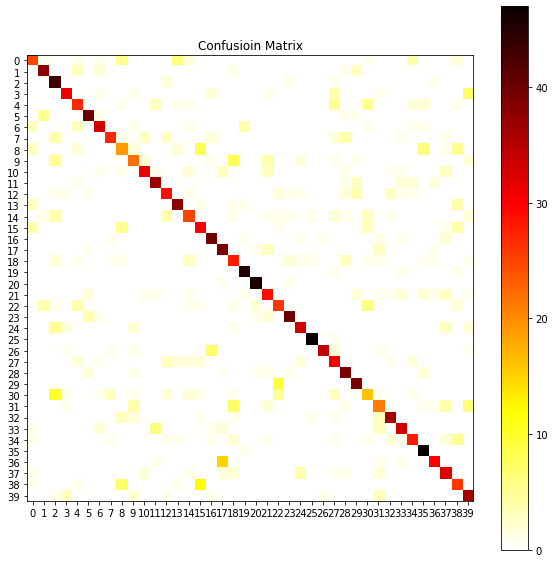

Accuracy of each class:
 tensor([0.5208, 0.7917, 0.8958, 0.6458, 0.5625, 0.8333, 0.6875, 0.5625, 0.3958,
        0.4583, 0.6458, 0.7708, 0.6042, 0.7917, 0.5208, 0.6250, 0.8333, 0.8125,
        0.5833, 0.9375, 0.9583, 0.6042, 0.5417, 0.8333, 0.6875, 0.9792, 0.7083,
        0.6458, 0.8125, 0.8125, 0.3333, 0.4375, 0.7500, 0.6875, 0.5833, 0.9792,
        0.6250, 0.6667, 0.5417, 0.7500])
Recall of each class:
 tensor([0.5952, 0.7755, 0.5658, 0.7750, 0.6000, 0.8000, 0.7500, 0.7941, 0.4419,
        0.5641, 0.7949, 0.7551, 0.6444, 0.7451, 0.5952, 0.5357, 0.7273, 0.6190,
        0.5185, 0.8491, 0.9020, 0.6170, 0.5909, 0.8511, 0.7500, 0.9400, 0.9444,
        0.5536, 0.7091, 0.7358, 0.4324, 0.5000, 0.8000, 0.7500, 0.6829, 0.7581,
        0.8108, 0.6154, 0.5200, 0.6207])
Epoch 36/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.0471
Step [20/60] Train Loss: 0.0496
Step [30/60] Train Loss: 0.0757
Step [40/60] Train Loss: 0.1031
Step [50/60] Train Loss: 0.1050
Step [60/60] Train Loss: 0.12

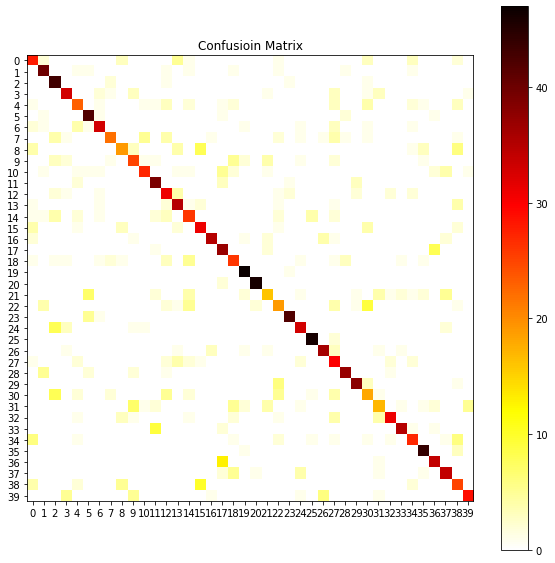

Accuracy of each class:
 tensor([0.5833, 0.8333, 0.8958, 0.6875, 0.4792, 0.8750, 0.6875, 0.4583, 0.3958,
        0.5208, 0.5625, 0.8125, 0.6458, 0.7292, 0.5417, 0.6458, 0.7292, 0.7708,
        0.5417, 0.9792, 0.9583, 0.3333, 0.3958, 0.8750, 0.6875, 0.9583, 0.7500,
        0.6250, 0.7708, 0.7917, 0.3750, 0.3542, 0.6458, 0.7292, 0.5625, 0.9167,
        0.7083, 0.7083, 0.5208, 0.6042])
Recall of each class:
 tensor([0.5091, 0.7273, 0.5890, 0.7021, 0.5476, 0.7119, 0.7674, 0.7333, 0.5588,
        0.5208, 0.7500, 0.6842, 0.5345, 0.6140, 0.5098, 0.5962, 0.8750, 0.5606,
        0.5306, 0.8246, 0.9388, 0.5161, 0.4524, 0.8936, 0.7174, 0.8846, 0.7660,
        0.4412, 0.8409, 0.8444, 0.3913, 0.5152, 0.8158, 0.8750, 0.6279, 0.8148,
        0.7083, 0.7083, 0.4630, 0.8056])
Epoch 37/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.0759
Step [20/60] Train Loss: 0.2227
Step [30/60] Train Loss: 0.1214
Step [40/60] Train Loss: 0.0661
Step [50/60] Train Loss: 0.1332
Step [60/60] Train Loss: 0.03

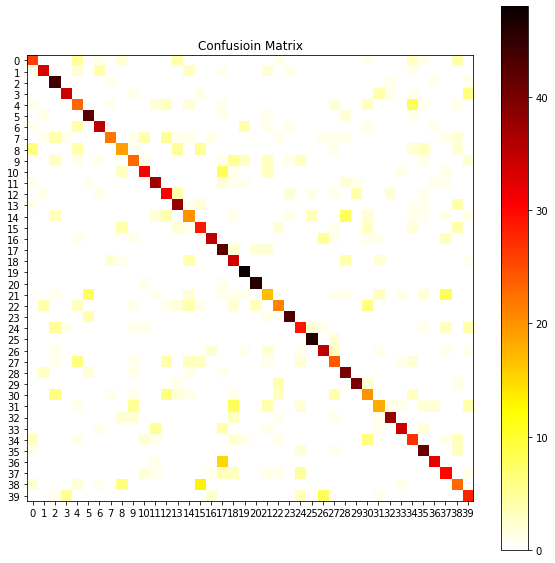

Accuracy of each class:
 tensor([0.5417, 0.6875, 0.9167, 0.7083, 0.4792, 0.8750, 0.7292, 0.4583, 0.3958,
        0.4792, 0.6458, 0.7708, 0.6458, 0.7917, 0.4167, 0.6042, 0.7292, 0.8750,
        0.7083, 1.0000, 0.9583, 0.3542, 0.4375, 0.8958, 0.6042, 0.9583, 0.7292,
        0.5000, 0.8333, 0.8333, 0.4167, 0.3750, 0.7917, 0.7083, 0.5625, 0.8542,
        0.6667, 0.6250, 0.4792, 0.5833])
Recall of each class:
 tensor([0.6047, 0.7674, 0.6377, 0.8293, 0.4340, 0.7368, 0.7955, 0.8148, 0.5135,
        0.5897, 0.7381, 0.7400, 0.5741, 0.6441, 0.4651, 0.5370, 0.8537, 0.5185,
        0.5312, 0.8136, 0.9020, 0.4359, 0.6000, 0.8776, 0.6170, 0.8846, 0.7000,
        0.5581, 0.6897, 0.8889, 0.4444, 0.5625, 0.8837, 0.8718, 0.5192, 0.7193,
        0.8649, 0.6000, 0.4894, 0.5714])
Epoch 38/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.0650
Step [20/60] Train Loss: 0.1582
Step [30/60] Train Loss: 0.0627
Step [40/60] Train Loss: 0.0940
Step [50/60] Train Loss: 0.1238
Step [60/60] Train Loss: 0.06

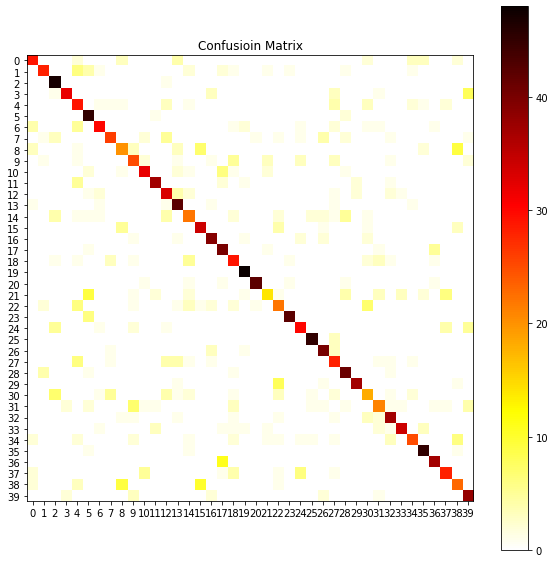

Accuracy of each class:
 tensor([0.6042, 0.5833, 0.9792, 0.6667, 0.6042, 0.9375, 0.6250, 0.5417, 0.4167,
        0.5208, 0.6667, 0.7708, 0.6875, 0.8750, 0.4583, 0.7083, 0.8125, 0.8333,
        0.6042, 1.0000, 0.8750, 0.2917, 0.4583, 0.8750, 0.6250, 0.9375, 0.8333,
        0.5833, 0.8542, 0.7708, 0.3750, 0.4375, 0.7708, 0.7083, 0.5208, 0.9375,
        0.7708, 0.5833, 0.4792, 0.7917])
Recall of each class:
 tensor([0.6744, 0.7778, 0.6912, 0.8889, 0.4265, 0.6164, 0.7692, 0.7027, 0.5000,
        0.5319, 0.7442, 0.8409, 0.5893, 0.6462, 0.5000, 0.6538, 0.7500, 0.6250,
        0.5370, 0.8727, 0.9545, 0.6087, 0.4889, 0.9333, 0.6818, 0.9000, 0.7547,
        0.5185, 0.7069, 0.9024, 0.4500, 0.5833, 0.7255, 0.8718, 0.7143, 0.8036,
        0.8043, 0.6829, 0.5111, 0.6552])
Epoch 39/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.0839
Step [20/60] Train Loss: 0.1355
Step [30/60] Train Loss: 0.0943
Step [40/60] Train Loss: 0.1115
Step [50/60] Train Loss: 0.0815
Step [60/60] Train Loss: 0.10

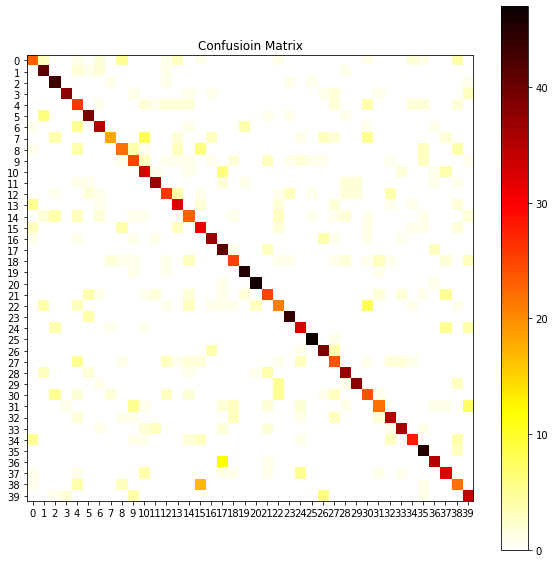

Accuracy of each class:
 tensor([0.4792, 0.8542, 0.8958, 0.7917, 0.5417, 0.8125, 0.7292, 0.3750, 0.4583,
        0.5208, 0.6875, 0.7708, 0.5417, 0.6667, 0.4792, 0.6458, 0.7708, 0.8542,
        0.5208, 0.9375, 0.9583, 0.5208, 0.4375, 0.9167, 0.6875, 0.9792, 0.8125,
        0.5000, 0.7708, 0.7917, 0.5000, 0.4583, 0.7292, 0.7500, 0.5833, 0.9375,
        0.7292, 0.6667, 0.4583, 0.7083])
Recall of each class:
 tensor([0.5610, 0.6949, 0.6935, 0.9268, 0.4333, 0.7358, 0.7447, 0.7500, 0.5789,
        0.5556, 0.5690, 0.8222, 0.6341, 0.6275, 0.5227, 0.4921, 0.7872, 0.5942,
        0.6757, 0.8654, 0.9200, 0.5952, 0.5000, 0.8627, 0.6735, 0.9216, 0.7091,
        0.5217, 0.7551, 0.9048, 0.5000, 0.6667, 0.7292, 0.8182, 0.7778, 0.7500,
        0.8140, 0.6275, 0.4583, 0.6182])
Epoch 40/40: , lr = 0.043199999999999995
Step [10/60] Train Loss: 0.1481
Step [20/60] Train Loss: 0.1412
Step [30/60] Train Loss: 0.0749
Step [40/60] Train Loss: 0.0798
Step [50/60] Train Loss: 0.0378
Step [60/60] Train Loss: 0.13

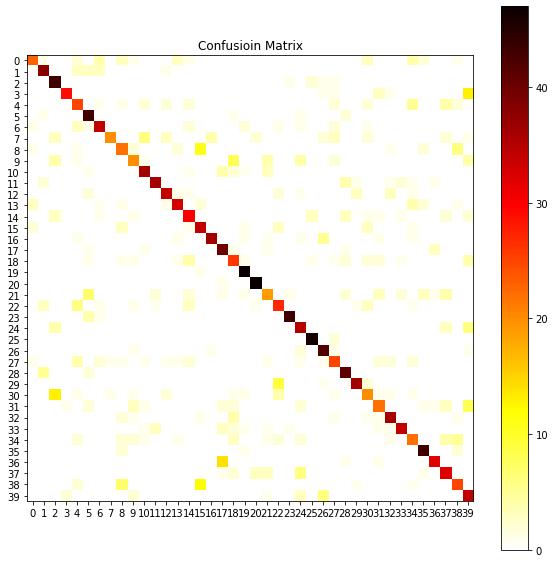

Accuracy of each class:
 tensor([0.4792, 0.7917, 0.8958, 0.6042, 0.5208, 0.8958, 0.7083, 0.4167, 0.4583,
        0.4167, 0.7500, 0.7500, 0.7083, 0.6875, 0.6250, 0.7083, 0.7500, 0.8333,
        0.5417, 0.9792, 0.9792, 0.3958, 0.5625, 0.8958, 0.7292, 0.9583, 0.8750,
        0.5208, 0.8542, 0.7500, 0.4167, 0.4583, 0.7500, 0.7083, 0.4583, 0.8958,
        0.6667, 0.6667, 0.5208, 0.7083])
Recall of each class:
 tensor([0.7419, 0.7600, 0.6143, 0.9062, 0.4902, 0.6418, 0.7083, 0.9091, 0.4889,
        0.5556, 0.7200, 0.8571, 0.7727, 0.7674, 0.6122, 0.5574, 0.8780, 0.6061,
        0.5000, 0.8246, 0.8868, 0.5429, 0.5625, 0.9348, 0.5932, 0.8846, 0.7119,
        0.5952, 0.7321, 0.8571, 0.5000, 0.5789, 0.7660, 0.8500, 0.5000, 0.7963,
        0.8421, 0.5926, 0.5814, 0.4658])


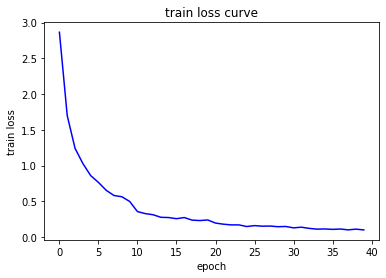

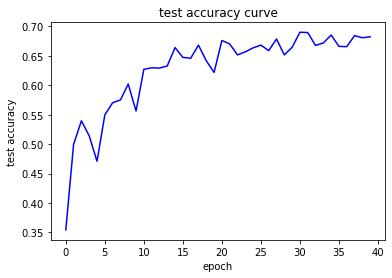

In [37]:
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #

In [38]:
training_dataset[0]

(tensor([[[-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
          [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
          [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
          ...,
          [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
          [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877],
          [-2.6877, -2.6877, -2.6877,  ..., -2.6877, -2.6877, -2.6877]],
 
         [[-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
          [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
          [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
          ...,
          [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
          [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715],
          [-2.2715, -2.2715, -2.2715,  ..., -2.2715, -2.2715, -2.2715]],
 
         [[-2.1025, -2.1025, -2.1025,  ..., -2.1025, -2.1025, -2.1025],
          [-2.1025, -2.1025,